# <p align="center">Siemens Sales Forecast</p>

---

## <p align="center">*1 - Exploratory Data Analysis & Pre-processing*</p>

---

### 👥 **Team Members**
- **Ana Farinha** *(Student Number: 20211514)*  
- **António Oliveira** *(Student Number: 20211595)*  
- **Mariana Neto** *(Student Number: 20211527)*  
- **Salvador Domingues** *(Student Number: 20240597)*  

📅 **Date:** *April 1, 2025*  
📍 **Prepared for:** *Siemens*  

**GitHub Repo:** https://github.com/MGN19/Siemens-forecast

---

# ToC

<a class="anchor" id="top"></a>


1. [Import Libraries & Data](#1.-Import-Libraries-&-Data) <br><br>

2. [Data Wrangling](#2.-Data-Wrangling) <br>

    2.1 [Sales Data](#2.1-Sales-Data) <br>
    
    2.2 [Market Data](#2.2-Market-Data) <br><br>

3. [Data Exploration](#3.-Data-Exploration) <br><br>

4. [Feature Exploration](#4.-Feature-Exploration) <br><br>

5. [Data Cleaning & Preprocessing](#5.-Data-Cleaning-&-Preprocessing) <br><br>
    5.1 [Duplicates](#5.1-Duplicates) <br>
    
    5.2 [Missing Values](#5.2-Missing-Values) <br>
    
    5.3 [Statistical Tests](#5.3-Statistical-Tests) <br>
    
    5.4 [Feature Engineering](#5.4-Feature-Engineering) <br>
    
    5.5 [Outliers](#5.5-Outliers) <br>

In [1]:
## CELL TYPES (remover depois)

<div class="alert-danger">
    
test

<div class="alert-warning">
    
test

<div class="alert-info">
    
test

# 1. Import Libraries & Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

#from ydata_profiling import ProfileReport



import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline


# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# External Files
import functions as f
import utils as u
import statistical_tests as st


pd.set_option('display.max_columns', None)

**Data**

In [3]:
test = pd.read_csv('data/Case2_Test Set Template.csv', 
                 sep = ';')

sales_data = pd.read_csv('./data/Case2_Sales data.csv', 
                 sep = ';')

market_data = pd.read_excel('./data/Case2_Market data.xlsx', 
                            index_col = 'Unnamed: 0')


# 2. Data Wrangling

<a href="#top">Top &#129033;</a>

- make necessarry changes to datasets to make them usable

## 2.1 Sales Data


In [4]:
sales_data.head(2)

DATE Mapped_GCK Sales_EUR
0  01.10.2018         #1         0
1  02.10.2018         #1         0

**Exploring the dataset structure with .info() method**

The `.info()` method provides more information about the dataset, including the existence of missing values and the data type of the elements of each row.

In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


With the information above, we can see the following:
- all of the columns in this dataset are categorical variables. For analysis purposes, the `DATE` column will be transformed into a date format, and the `Sales_EUR` column into a float. 
- we can also see that there might not be any missing values in any of the columns of the dataset.

Based on this, we will first change the data types of these 2 columns identified so that analysis can be proprerly made.

In [6]:
# convert to datetime
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], 
                                    format='%d.%m.%Y')

# convvert to numbers
sales_data['Sales_EUR'] = sales_data['Sales_EUR'].apply(lambda x: x.replace(',', '.')).astype(float)

sales_data.head(1)

DATE Mapped_GCK  Sales_EUR
0 2018-10-01         #1        0.0

**Convert to Monthly Data**

In [7]:
# convert to montlhy sales
sales_data["Date"] = sales_data["DATE"].dt.to_period("M")
monthly_sales = sales_data.groupby(["Date", 
                                     "Mapped_GCK"]).agg({"Sales_EUR": "sum"}).reset_index()

monthly_sales.head(7)

Date Mapped_GCK    Sales_EUR
0  2018-10         #1  36098918.79
1  2018-10        #11   1021303.50
2  2018-10        #12     28686.33
3  2018-10        #13     27666.10
4  2018-10        #14      5770.00
5  2018-10        #16    333196.87
6  2018-10        #20      4563.14

Make each Product categ a column

In [8]:
new_monthly_sales = monthly_sales.pivot(index='Date', 
                                 columns='Mapped_GCK', 
                                 values='Sales_EUR')

**Save index as timestamp**

In [9]:
new_monthly_sales.index = new_monthly_sales.index.to_timestamp()

**Reorder Columns**

looks nicer

In [10]:
new_order = ['#1', '#3', '#4', '#5', '#6', '#8', '#9', 
             '#11', '#12', '#13', '#14', '#16', '#20', 
             '#36']

new_monthly_sales = new_monthly_sales[new_order]
new_monthly_sales.head(3)

Mapped_GCK           #1           #3         #4          #5         #6  \
Date                                                                     
2018-10-01  36098918.79   8089465.96  397760.69  2499061.19  369231.60   
2018-11-01   5140760.00  11863001.51  371322.42  8993944.04  473046.96   
2018-12-01  37889612.12   8736859.39  430100.96  6947507.31  999472.69   

Mapped_GCK         #8       #9        #11       #12       #13      #14  \
Date                                                                     
2018-10-01  586052.74  3219.32  1021303.5  28686.33  27666.10   5770.0   
2018-11-01  526292.77  1875.90  1898844.8   1070.00  68180.00  17130.0   
2018-12-01  271490.71     0.00  1226122.0  17880.60  15655.18      0.0   

Mapped_GCK         #16      #20       #36  
Date                                       
2018-10-01   333196.87  4563.14   6474.60  
2018-11-01  1377694.32  5798.14  21617.61  
2018-12-01  4762524.66   918.65  13924.52

## 2.2 Market Data

<a href="#top">Top &#129033;</a>

In [11]:
market_data.head(3)

China  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO156   
 2004m2                                                                 16.940704   

                                                                         China.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP156   
 2004m2                                                                16.940704   

                                                                           France  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO250   
 2004m2                                                                112.091273   

                                                                        France.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP250   
 2004m2                                                                83.458866   

                                                                          Germany  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO276   
 2004m2                                                                 82.623037   

                                                                       Germany.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP276   
 2004m2                                                                79.452532   

                                                                            Italy  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO380   
 2004m2                                                                124.289603   

                                                                         Italy.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP380   
 2004m2                                                                86.560493   

                                                                            Japan  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO392   
 2004m2                                                                 109.33401   

                                                                         Japan.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP392   
 2004m2                                                               110.495272   

                                                                      Switzerland  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO756   
 2004m2                                                                 91.221862   

                                                                   Switzerland.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP756   
 2004m2                                                                89.987275   

        

In [12]:
info = market_data.T.iloc[:, :2]
info

Index 2010=100 (if not otherwise noted)  \
China                      Production Index Machinery & Electricals   
China.1                     Shipments Index Machinery & Electricals   
France                     Production Index Machinery & Electricals   
France.1                    Shipments Index Machinery & Electricals   
Germany                    Production Index Machinery & Electricals   
Germany.1                   Shipments Index Machinery & Electricals   
Italy                      Production Index Machinery & Electricals   
Italy.1                     Shipments Index Machinery & Electricals   
Japan                      Production Index Machinery & Electricals   
Japan.1                     Shipments Index Machinery & Electricals   
Switzerland                Production Index Machinery & Electricals   
Switzerland.1               Shipments Index Machinery & Electricals   
United Kingdom             Production Index Machinery & Electricals   
United Kingdom.1            Shipments Index Machinery & Electricals   
United States              Production Index Machinery & Electricals   
United States.1             Shipments Index Machinery & Electricals   
Europe                     Production Index Machinery & Electricals   
Europe.1                    Shipments Index Machinery & Electricals   
Unnamed: 19                             World: Price of Base Metals   
Unnamed: 20                                  World: Price of Energy   
Unnamed: 21                      World: Price of Metals  & Minerals   
Unnamed: 22                       World: Price of Natural gas index   
Unnamed: 23                      World: Price of Crude oil, average   
Unnamed: 24                                  World: Price of Copper   
Unnamed: 25                               United States: EUR in LCU   
Producer Prices                 United States: Electrical equipment   
Producer Prices.1              United Kingdom: Electrical equipment   
Producer Prices.2                       Italy: Electrical equipment   
Producer Prices.3                      France: Electrical equipment   
Producer Prices.4                     Germany: Electrical equipment   
Producer Prices.5                       China: Electrical equipment   
production index      United States: Machinery and equipment n.e.c.   
production index.1            World: Machinery and equipment n.e.c.   
production index.2      Switzerland: Machinery and equipment n.e.c.   
production index.3   United Kingdom: Machinery and equipment n.e.c.   
production index.4            Italy: Machinery and equipment n.e.c.   
production index.5            Japan: Machinery and equipment n.e.c.   
production index.6           France: Machinery and equipment n.e.c.   
production index.7          Germany: Machinery and equipment n.e.c.   
production index.8              United States: Electrical equipment   
production index.9                      World: Electrical equipment   
production index.10               Switzerland: Electrical equipment   
production index.11            United Kingdom: Electrical equipment   
production index.12                     Italy: Electrical equipment   
production index.13                     Japan: Electrical equipment   
production index.14                    France: Electrical equipment   
production index.15                   Germany: Electrical equipment   

                                       date  
China                        MAB_ELE_PRO156  
China.1                      MAB_ELE_SHP156  
France                       MAB_ELE_PRO250  
France.1                     MAB_ELE_SHP250  
Germany                      MAB_ELE_PRO276  
Germany.1                    MAB_ELE_SHP276  
Italy                        MAB_ELE_PRO380  
Italy.1                      MAB_ELE_SHP380  
Japan                        MAB_ELE_PRO392  
Japan.1                      MAB_ELE_SHP392  
Switzerland                  MAB_ELE_PRO756  
Switzerland.1                MAB_ELE_SHP756  
United Kingdom       

Rename Cols

In [13]:
market_data = market_data.rename(columns = u.rename_dict)

Remove unnecessary rows

In [14]:
market_data = market_data.reset_index()
market_data = market_data[2:]
market_data.rename(columns={'index': 'Date'}, inplace=True)
market_data

Date CHI Production Index CHI Shipments Index FRA Production Index  \
2     2004m2            16.940704           16.940704           112.091273   
3     2004m3            23.711852           23.711852           136.327976   
4     2004m4            24.435235           24.435235           117.791806   
5     2004m5            23.708115           23.708115           109.002541   
6     2004m6            27.009138           27.009138           133.785737   
..       ...                  ...                 ...                  ...   
216  2021m12           310.763183          310.763183           100.565744   
217   2022m1           235.956129          235.956129            85.743503   
218   2022m2           235.956129          235.956129             90.60354   
219   2022m3           329.413367          329.413367           107.843548   
220   2022m4           267.373145          267.373145             87.69811   

    FRA Shipments Index GER Production Index GER Shipments Index  \
2             83.458866            82.623037           79.452532   
3            106.168192           100.556582           97.012918   
4             92.007646            89.653203           84.932358   
5             85.696486            86.880571           82.372794   
6            106.641482            99.010814            95.10874   
..                  ...                  ...                 ...   
216          134.589504           118.103281          149.364286   
217           108.15632             94.55061          120.353403   
218           117.71577           103.987916          129.383676   
219           136.85872           121.308119          151.201314   
220          116.528738            99.522205          127.022869   

    ITA Production Index ITA Shipments Index JAP Production Index  \
2             124.289603           86.560493            109.33401   
3             143.411662          106.344544           140.884616   
4             129.083828           95.579673           105.853579   
5             135.590391          100.087039           101.864777   
6             136.424935          110.889719            120.33292   
..                   ...                 ...                  ...   
216            94.006826          150.482735           127.771735   
217            86.851008          101.258277           110.460181   
218           106.583758          120.956538           117.879631   
219           124.637966          153.645142           152.000561   
220            103.55669          128.733305           114.262328   

    JAP Shipments Index SWI Production Index SWI Shipments Index  \
2            110.495272            91.221862           89.987275   
3            144.686166            85.866287           79.883583   
4            102.655769            85.622508           79.740802   
5            100.305285            85.378729           79.598021   
6             119.61638             85.13495           79.455239   
..                  ...                  ...                 ...   
216          131.029703           106.704029          104.819189   
217          110.823532            103.49926           101.70157   
218          118.300232           100.294492           98.583952   
219          156.400634            97.089723           95.466333   
220          115.012049                  NaN                 NaN   

    UK Production Index UK Shipments Index USA Production Index  \
2            111.353812          73.601265             107.6014   
3            127.558608          84.047595           110.187364   
4            108.732297          73.026027           108.166564   
5              110.6452          74.591883           108.425887   
6             122.02096          82.343346           110.569933   
..                  ...                ...                  ...   
216          101.273544                NaN           107.040766   
217           95.003541                NaN           111.052133   
218  

Convert dates to datetime

In [15]:
# convert to datetime
market_data["Year"] = market_data["Date"].str.extract(r"(\d{4})").astype(int)
market_data["Month"] = market_data["Date"].str.extract(r"m(\d{1,2})").astype(int)

market_data["Date"] = pd.to_datetime(market_data["Year"].astype(str) + "-" + market_data["Month"].astype(str), format="%Y-%m").dt.to_period("M")

market_data.drop(['Year', 'Month'], axis = 1, inplace = True)

Convert numbers to float

In [16]:
for column in market_data.columns:
    if column in ['Date', 'Month', 'Year']:
        continue
    else:
        market_data[column] = market_data[column].astype(str).str.replace(',', '.', regex=False)
        market_data[column] = pd.to_numeric(market_data[column], errors='coerce')

In [17]:
market_data.set_index('Date', inplace=True)

**Save index as timestamp**

In [18]:
market_data.index = market_data.index.to_timestamp()

In [19]:
market_data.head(4)

CHI Production Index  CHI Shipments Index  FRA Production Index  \
Date                                                                          
2004-02-01             16.940704            16.940704            112.091273   
2004-03-01             23.711852            23.711852            136.327976   
2004-04-01             24.435235            24.435235            117.791806   
2004-05-01             23.708115            23.708115            109.002541   

            FRA Shipments Index  GER Production Index  GER Shipments Index  \
Date                                                                         
2004-02-01            83.458866             82.623037            79.452532   
2004-03-01           106.168192            100.556582            97.012918   
2004-04-01            92.007646             89.653203            84.932358   
2004-05-01            85.696486             86.880571            82.372794   

            ITA Production Index  ITA Shipments Index  JAP Production Index  \
Date                                                                          
2004-02-01            124.289603            86.560493            109.334010   
2004-03-01            143.411662           106.344544            140.884616   
2004-04-01            129.083828            95.579673            105.853579   
2004-05-01            135.590391           100.087039            101.864777   

            JAP Shipments Index  SWI Production Index  SWI Shipments Index  \
Date                                                                         
2004-02-01           110.495272             91.221862            89.987275   
2004-03-01           144.686166             85.866287            79.883583   
2004-04-01           102.655769             85.622508            79.740802   
2004-05-01           100.305285             85.378729            79.598021   

            UK Production Index  UK Shipments Index  USA Production Index  \
Date                                                                        
2004-02-01           111.353812           73.601265            107.601400   
2004-03-01           127.558608           84.047595            110.187364   
2004-04-01           108.732297           73.026027            108.166564   
2004-05-01           110.645200           74.591883            108.425887   

            USA Shipments Index  Europe Production Index  \
Date                                                       
2004-02-01            79.240230                97.122911   
2004-03-01            98.619024               113.783904   
2004-04-01            89.774031               101.715199   
2004-05-01            87.463813               101.275727   

            Europe Shipments Index  (W) Price of Base Metals  \
Date                                                           
2004-02-01               80.098530                 54.039811   
2004-03-01               96.015929                 54.666162   
2004-04-01               85.167236                 54.872715   
2004-05-01               84.485767                 51.230356   

            (W) Price of Energy  (W) Price of Metals & Minerals  \
Date                                                              
2004-02-01            44.123338                       48.747945   
2004-03-01            47.588957                       49.256157   
2004-04-01            47.779013                       49.423751   
2004-05-01            53.590898                       46.468392   

            (W) Price of Natural gas index  (W) Price of Crude oil, average  \
Date                                                                          
2004-02-01                       87.076974                        39.639458   
2004-03-01                       87.192705                        42.592034   
2004-04-01                       91.379923                        42.650637   
2004-05-01                       99.044520                        47.517121   

            (W) Price of Copper  USA 

# 3. Data Exploration

<a href="#top">Top &#129033;</a>

### Initial Sales Data Exploration

In [20]:
# profile = ProfileReport(
#     new_monthly_sales, 
#     title='Data',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

# profile

- #11 is highly overall correlated with #8	
- #12 is highly overall correlated with #3 and 1 other fields	
- #3 is highly overall correlated with #12 and 1 other fields	
- #5 is highly overall correlated with #3	
- #8 is highly overall correlated with #11 and 2 other fields

<br>

**Statistics**

By using the `describe()` method we get different statistical measurements, such as mean and standard deviation, for the various features. We will include the parameter 'all' so both statistics for numerical and categorical data appear. 

In [21]:
new_monthly_sales.describe().T

count          mean           std         min           25%  \
Mapped_GCK                                                                
#1           43.0  3.591177e+07  5.905117e+06  5140760.00  3.440896e+07   
#3           43.0  1.240566e+07  2.577332e+06  3804319.74  1.105907e+07   
#4           43.0  3.634234e+05  1.557109e+05    93226.32  2.797995e+05   
#5           43.0  9.990585e+06  3.731564e+06  1405295.36  7.703432e+06   
#6           43.0  4.800440e+05  2.422862e+05   -15202.96  3.160555e+05   
#8           43.0  8.109586e+05  5.436111e+05   111791.34  3.749379e+05   
#9           43.0  7.173175e+03  8.231269e+03    -4358.10  1.626700e+03   
#11          43.0  1.532589e+06  9.811598e+05    18200.00  9.035992e+05   
#12          43.0  1.925462e+05  1.410168e+05     1070.00  3.923521e+04   
#13          43.0  2.346877e+04  1.614016e+04     2550.31  1.046647e+04   
#14          43.0  1.148423e+04  1.611617e+04    -2851.45  2.015025e+03   
#16          43.0  4.277018e+05  7.824899e+05    40360.08  1.375541e+05   
#20          43.0  1.821555e+03  2.307900e+03        0.00  3.308100e+02   
#36          43.0  2.322358e+04  4.265128e+04      674.00  6.244495e+03   

                    50%           75%          max  
Mapped_GCK                                          
#1          37323903.07  3.888867e+07  44483013.86  
#3          12317479.75  1.377567e+07  18686819.85  
#4            329430.96  4.281612e+05    829442.33  
#5           9232237.68  1.180077e+07  19524640.52  
#6            499147.73  6.119871e+05    999472.69  
#8            599831.93  1.092310e+06   2655036.78  
#9              4488.09  9.583200e+03     39510.75  
#11          1226122.00  2.161184e+06   3891447.76  
#12           172712.88  3.217950e+05    445648.06  
#13            20663.64  3.096641e+04     68180.00  
#14             5951.85  1.530589e+04     76161.44  
#16           224501.90  3.283725e+05   4762524.66  
#20              842.93  2.543020e+03      8485.60  
#36            12377.77  2.199505e+04    253519.04

- negative sales values #14, #6, #9

### Initial Market Data Exporation

In [22]:
# profile2 = ProfileReport(
#     market_data, 
#     title='Data',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

# profile2

In [23]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2004-02-01 to 2022-04-01
Freq: MS
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CHI Production Index             219 non-null    float64
 1   CHI Shipments Index              219 non-null    float64
 2   FRA Production Index             219 non-null    float64
 3   FRA Shipments Index              219 non-null    float64
 4   GER Production Index             219 non-null    float64
 5   GER Shipments Index              219 non-null    float64
 6   ITA Production Index             219 non-null    float64
 7   ITA Shipments Index              219 non-null    float64
 8   JAP Production Index             219 non-null    float64
 9   JAP Shipments Index              219 non-null    float64
 10  SWI Production Index             218 non-null    float64
 11  SWI Shipments Index              218 non-null    float64

With the information above, we can see the following:
- `date` could be set as index, since there is no duplicated date
- all of the columns in this dataset are stored as categorical variables, except `date`. Therefore, some modifications regarding data types might happen, because these columns' values represent prices and would be more appropriate to store as floats.
- we can also see that there are missing values on `SWI_MC_EL_PROD`, `SWI_MC_EL_SHIP`, `UK_MC_EL_SHIP`, `USA_MC_EL_SHIP`, `UK_EE_PRODUCER_PRICE`, `FRA_EE_PRODUCER_PRICE`, `CHI_EE_PRODUCER_PRICE`, `CHI_MC_EQ_PROD`, `WRL_EE_PROD` and `SWI_EE_PROD`. However, these missing values might be due to the fact that not all countries have, for instance, producers.

We will proceed to change the datatypes of all columns, except `date`, to float and set `date` as index.

**Statistics**

In [24]:
market_data.describe()

CHI Production Index  CHI Shipments Index  FRA Production Index  \
count            219.000000           219.000000            219.000000   
mean             138.303637           138.303637            104.431918   
std               78.883209            78.883209             18.918529   
min               16.940704            16.940704             50.756680   
25%               68.477740            68.477740             93.613505   
50%              133.507690           133.507690            102.736556   
75%              198.473934           198.473934            114.090851   
max              329.413367           329.413367            152.743402   

       FRA Shipments Index  GER Production Index  GER Shipments Index  \
count           219.000000            219.000000           219.000000   
mean            105.316814            107.499126           114.898377   
std              12.762209             11.861942            17.091571   
min              64.420676             74.332913            71.787161   
25%              97.452819            100.560897           103.149778   
50%             106.012166            108.992290           117.428836   
75%             115.030479            115.735786           127.112220   
max             136.858720            130.869962           151.297092   

       ITA Production Index  ITA Shipments Index  JAP Production Index  \
count            219.000000           219.000000            219.000000   
mean             105.228363           105.735378            111.948146   
std               23.509638            19.948183             15.489336   
min               34.213427            45.191710             67.531940   
25%               94.335162            95.985839            103.740049   
50%              105.088474           107.695805            111.683015   
75%              117.031701           119.836360            121.402653   
max              153.940791           153.645142            153.898678   

       JAP Shipments Index  SWI Production Index  SWI Shipments Index  \
count           219.000000            218.000000           218.000000   
mean            112.670602             97.834543            94.784942   
std              16.891947              8.241523             9.153899   
min              64.372344             77.801503            74.639253   
25%             103.453182             92.410183            88.221030   
50%             112.597293             97.573131            94.376831   
75%             121.498141            103.877063           100.736473   
max             159.495942            116.674608           115.321078   

       UK Production Index  UK Shipments Index  USA Production Index  \
count           219.000000          201.000000            219.000000   
mean            108.752949           95.957072            109.418255   
std              12.096725           12.946170              7.891270   
min              61.048022           57.462935             85.994448   
25%             100.498418           86.199717            104.599964   
50%             108.911029           97.868918            110.153555   
75%             118.001772          105.269576            114.585399   
max             137.682590          126.338522            126.650773   

       USA Shipments Index  Europe Production Index  Europe Shipments Index  \
count           218.000000               219.000000              219.000000   
mean            114.160028               108.779990              110.551132   
std              14.633380                11.839462               15.727859   
min              79.240230                69.786633               71.158884   
25%             104.596526               101.729625               98.588003   
50%             115.713379               110.383833              111.954128   
75%             123.419976               115.832526              121.613878   
max             165.926217               134.216163              158.055622 

Based on this, we get the following:

1. **Production and Shipments in Machinery & Electricals**  
   - China’s production and shipment index show high variability, indicating for instance fluctuations in demand, supply chain issues, or policy impacts.
   - At some point in time, Production and Shipments was over 3 times higher than in 2010 (229% increase)
   China was producing 38% more than in 2010 and in terms of other countries it was always higher.
   - Switzerland has the lowest mean production and shipment index, compared to the other countries.
   - UK tends to produce more than export
   - Germany’s shipment index mean (114.9) is higher than its production mean (107.5), which could indicate a focus on exports or strong international demand.

3. **Material Prices**  
   - Gas prices (mean: 103.37, std: 41.74) show high volatility, likely driven by geopolitical factors and global supply-demand shocks.  
   - Copper and metal price have a lower mean (86.34) than other metals.
   - Oil prices have a high range (26.62–168.05), reflecting the impact of market cycles and demand shifts.  

4. **Producer Prices vs. Production Indices (Electrical Equipment)**  
   - Germany has the highest producer price mean (103.17), closely followed by USA (103.17) and Italy (102.16). This suggests that companies in these countries are paying more to produce goods.  
   - Switzerland’s mean producer price is lower than others (97.68).
   - On average, UK had produce more than other countries (116), followed by the USA (110).

5. **Machinery & Equipment Production Trends**  
   - Japan has the highest production mean (115.08), followed by Germany (110.90) and the U.S. (110.42), indicating a strong machinery sector production.  
   - Switzerland has the lowest production indexes (on average 99.7).

# 4. Feature Exploration

<a href="#top">Top &#129033;</a>

## 4.1 Univariate Analysis

<a href="#top">Top &#129033;</a>

**Sales Data**

In [25]:
f.plot_boxplots(new_monthly_sales)

<br>

**Market Data**

In [26]:
if isinstance(market_data.index, pd.PeriodIndex):
    market_data.index = market_data.index.to_timestamp()
market_data_resampled = market_data.resample('MS').sum()

In [27]:
resources_prices = [
    '(W) Price of Base Metals', '(W) Price of Energy', '(W) Price of Metals & Minerals',
    '(W) Price of Natural gas index', '(W) Price of Crude oil, average', '(W) Price of Copper'
]

f.resource_prices(market_data_resampled, resources_prices)


In [28]:
prod_ship_index = market_data_resampled.iloc[:, 0:18] 

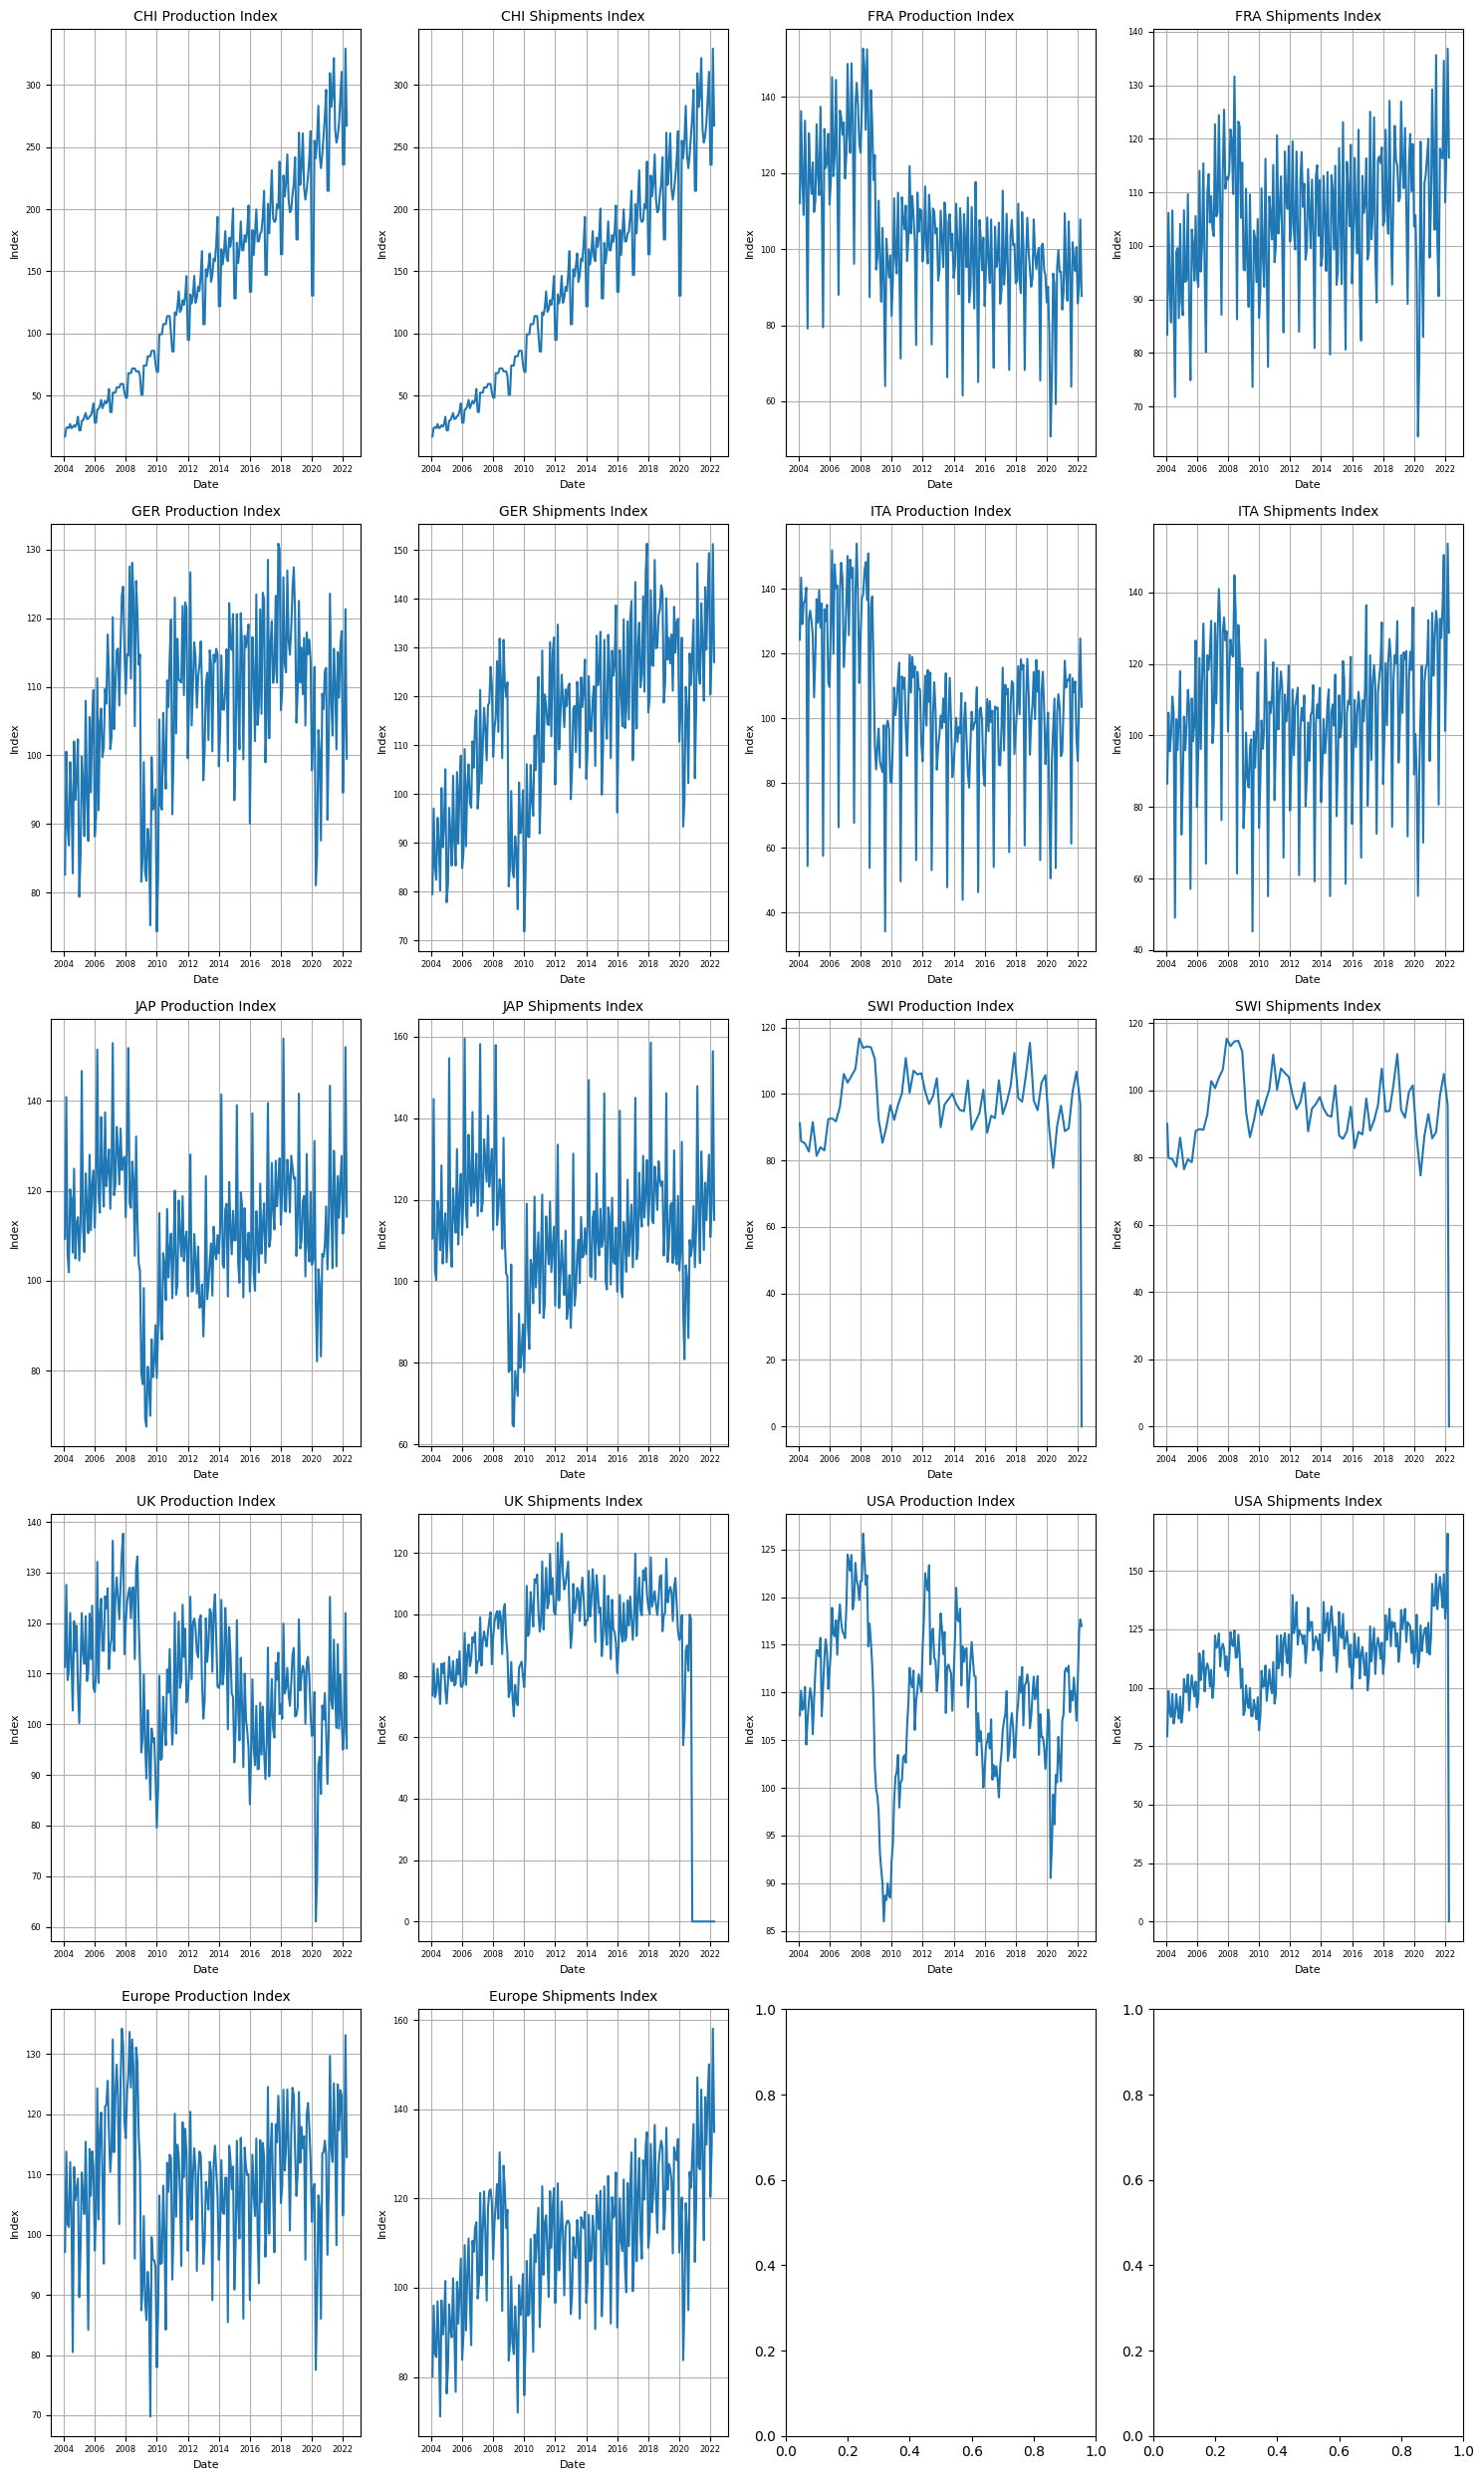

In [29]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 25))

axes = axes.flatten()

for i, column in enumerate(prod_ship_index.columns):  
    ax = axes[i]
    ax.plot(prod_ship_index.index, prod_ship_index[column])  
    ax.set_title(column, fontsize=10)
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('Index', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
production_columns = [
    'CHI Production Index', 'FRA Production Index', 'GER Production Index', 
    'ITA Production Index', 'JAP Production Index', 'SWI Production Index',
    'UK Production Index', 'USA Production Index', 'Europe Production Index'
]
production_data = market_data_resampled[production_columns]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in production_columns:
    trace = go.Scatter(
        x=production_data.index,  
        y=production_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title="Production Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Production Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [31]:
producer_prices = ['USA EE Producer Prices', 'UK EE Producer Prices',
                     'ITA EE Producer Prices', 'FRA EE Producer Prices',
                     'GER EE Producer Prices', 'CHI EE Producer Prices',
]
producer_price_data = market_data_resampled[producer_prices]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in producer_prices:
    trace = go.Scatter(
        x=producer_price_data.index,  
        y=producer_price_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title="Producer Price Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Production Price'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [32]:
shipment_columns = [
    'CHI Shipments Index', 'FRA Shipments Index', 'GER Shipments Index', 
    'ITA Shipments Index', 'JAP Shipments Index', 'SWI Shipments Index',
    'UK Shipments Index', 'USA Shipments Index', 'Europe Shipments Index'
]
shipment_data = market_data_resampled[shipment_columns]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in shipment_columns:
    trace = go.Scatter(
        x=shipment_data.index,  
        y=shipment_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title="Shipment Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Shipment Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [33]:
me_index = ['USA Machinery & Equipment Index', '(W) Machinery & Equipment Index',
       'SWI Machinery & Equipment Index', 'UK Machinery & Equipment Index',
       'ITA Machinery & Equipment Index', 'JAP Machinery & Equipment Index',
       'FRA Machinery & Equipment Index', 'GER Machinery & Equipment Index'
]

me_index_data = market_data_resampled[me_index]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in me_index:
    trace = go.Scatter(
        x=me_index_data.index,  
        y=me_index_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title=" Machinery & Equipment Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [34]:
ee_index = ['USA EE Production Index', '(W) EE Production Index',
       'SWI EE Production Index', 'UK EE Production Index',
       'ITA EE Production Index', 'JAP EE Production Index',
       'FRA EE Production Index', 'GER EE Production Index'
]

ee_index_data = market_data_resampled[ee_index]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in ee_index:
    trace = go.Scatter(
        x=ee_index_data.index,  
        y=ee_index_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title=" Eletronic Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

## 4.2 Bivariate Analysis

<a href="#top">Top &#129033;</a>

**Sales Data**

Percentage of each product per year

In [35]:
copy = new_monthly_sales.copy().reset_index()
copy["Year"] = copy["Date"].dt.year
copy = copy.drop(columns=["Date"])
yearly_data = copy.groupby("Year").sum()
df_percent = yearly_data.div(yearly_data.sum(axis=1), axis=0) * 100
df_percent = df_percent.round(0).astype(int).astype(str) + "%"
df_percent


Mapped_GCK   #1   #3  #4   #5  #6  #8  #9 #11 #12 #13 #14 #16 #20 #36
Year                                                                 
2018        56%  20%  1%  13%  1%  1%  0%  3%  0%  0%  0%  5%  0%  0%
2019        59%  19%  1%  16%  1%  1%  0%  2%  0%  0%  0%  1%  0%  0%
2020        59%  20%  1%  16%  1%  1%  0%  3%  0%  0%  0%  0%  0%  0%
2021        56%  20%  1%  17%  1%  2%  0%  3%  0%  0%  0%  0%  0%  0%
2022        59%  21%  0%  15%  0%  2%  0%  2%  0%  0%  0%  0%  0%  0%

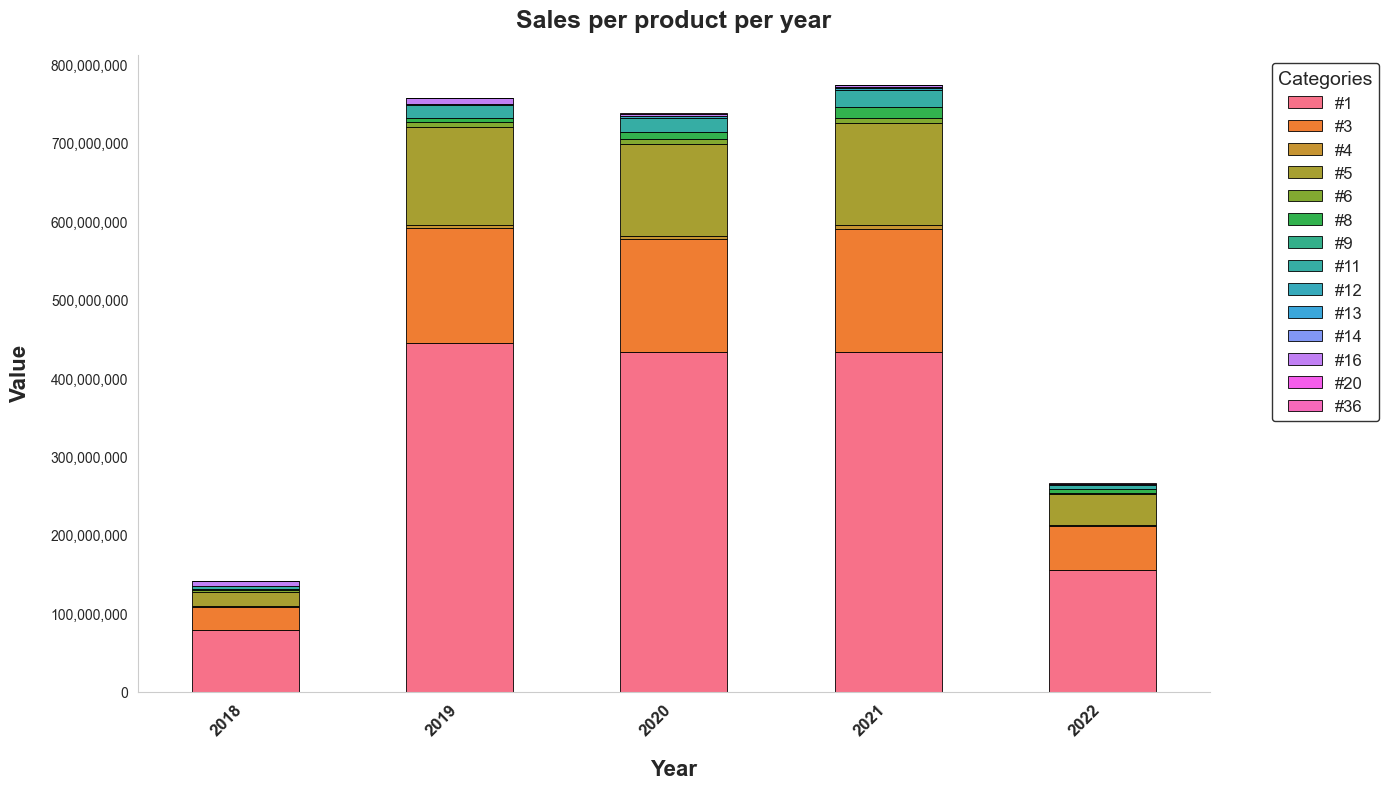

In [36]:
f.plot_stacked_bar(yearly_data)

Pairwise relationship between products

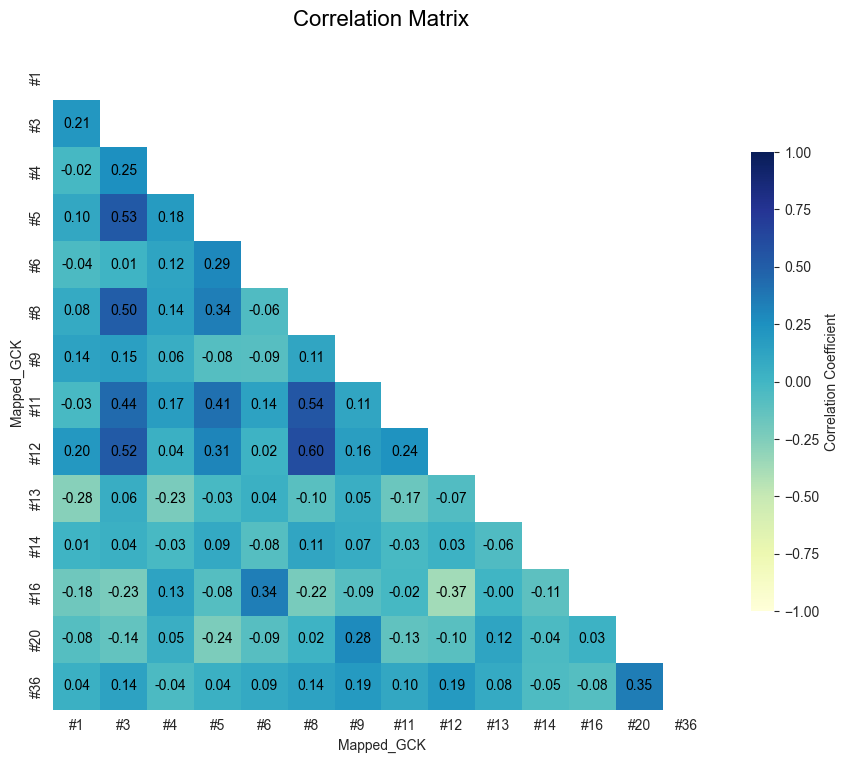

In [37]:
corr = np.round(new_monthly_sales.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

In [38]:
f.plot_high_correlation_pairs(new_monthly_sales)

In [39]:
fig = f.monthly_sales_per_year(new_monthly_sales)
fig.show()

ver sales trend por year

In [40]:
f.monthly_sales(new_monthly_sales)

In [41]:
f.percentage_change(new_monthly_sales)

In [42]:
f.percentage_change_previous_month(new_monthly_sales)

https://online.stat.psu.edu/stat510/lesson/5/5.1

In [43]:
f.multiplicative_seasonal_decomposition(new_monthly_sales, excluded_columns=['#14', '#20', '#6', '#9'])

Dropdown(description='Select Column:', options=('#1', '#3', '#4', '#5', '#8', '#11', '#12', '#13', '#16', '#36…

Output()

In [44]:
f.additive_seasonal_decomposition(new_monthly_sales, excluded_columns=['#14', '#20', '#6', '#9'])

Dropdown(description='Select Column:', options=('#1', '#3', '#4', '#5', '#8', '#11', '#12', '#13', '#16', '#36…

Output()

<br>

**Market Data**

Production and Shipment Index

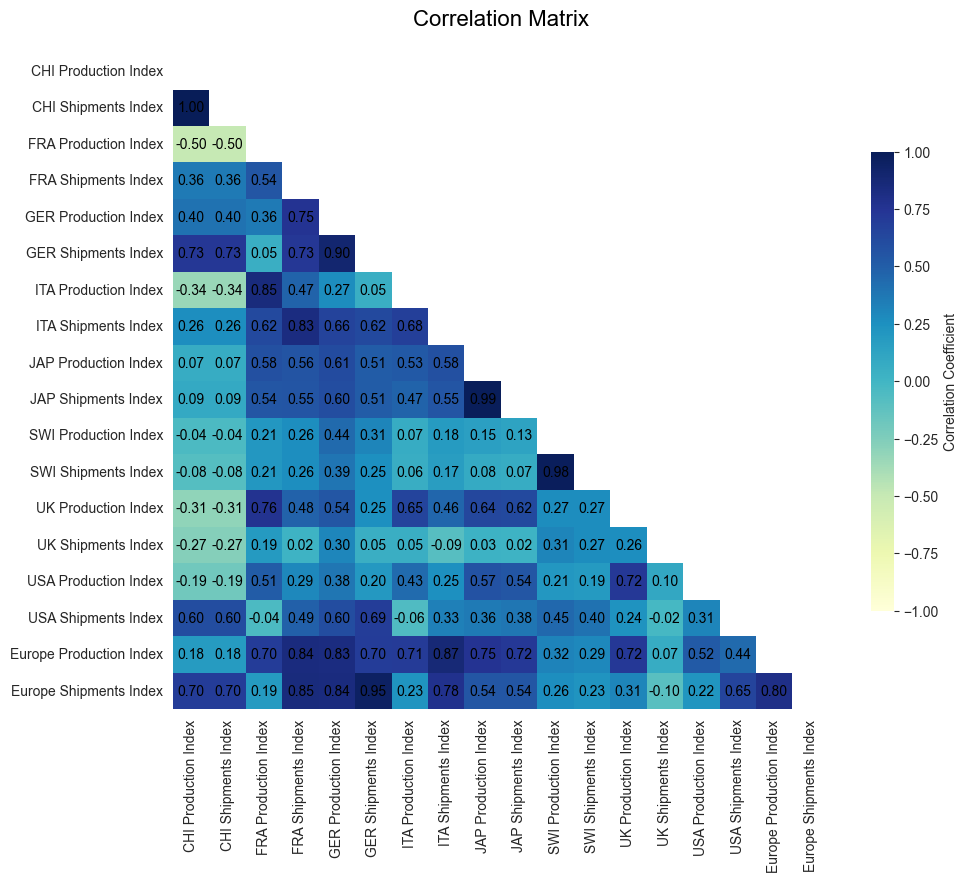

In [45]:
prod_ship_index = market_data_resampled.iloc[:, 0:18] 
corr = np.round(prod_ship_index.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Prices Indexes

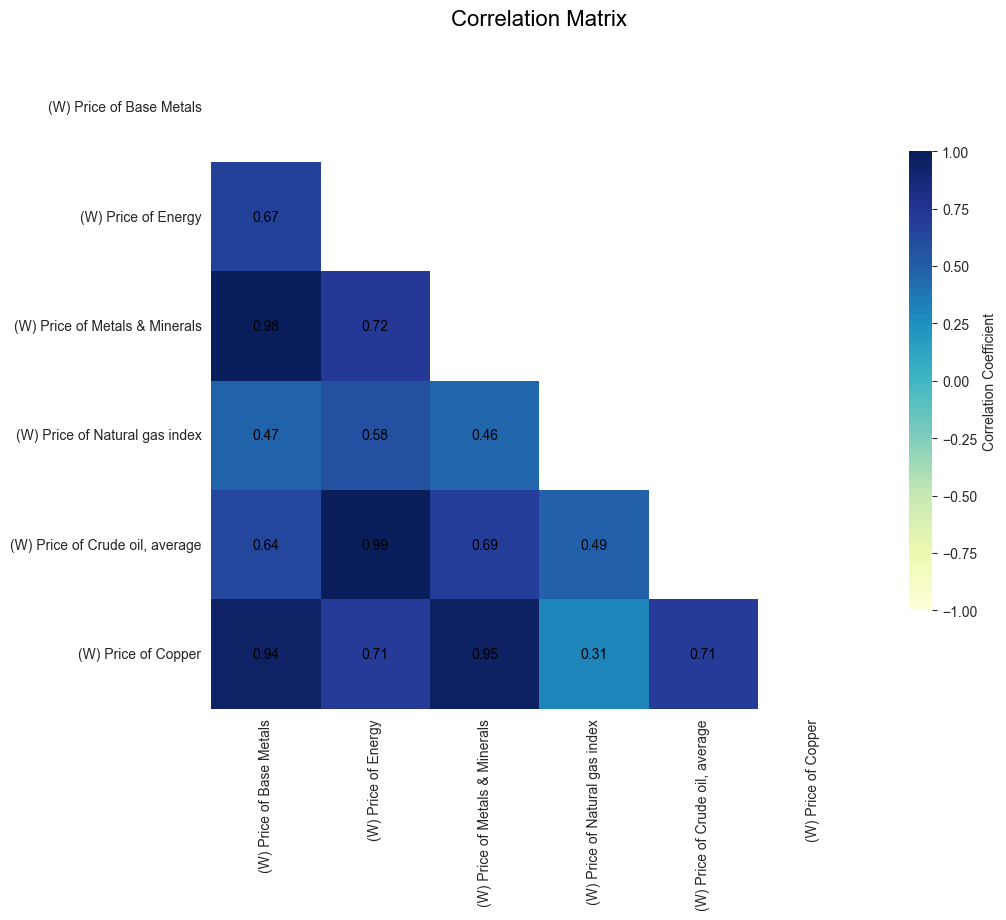

In [46]:
corr = np.round(market_data_resampled[resources_prices].corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Producer Prices Electrical Equipment

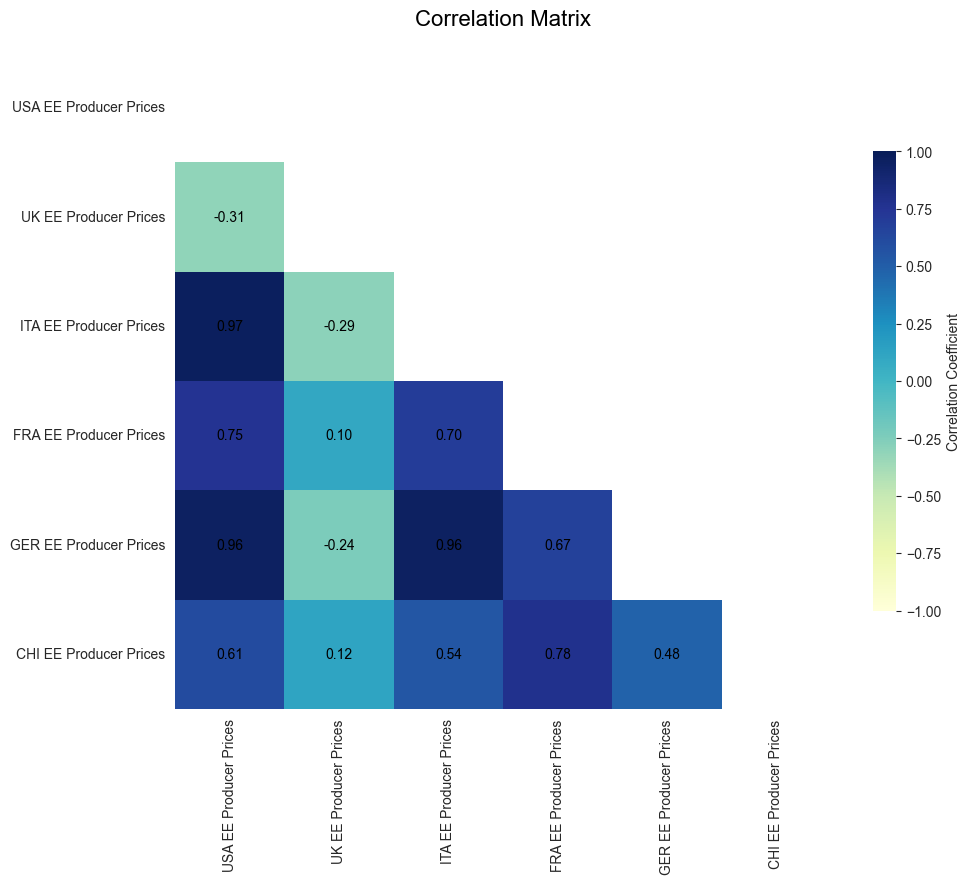

In [47]:
corr = np.round(market_data_resampled[producer_prices].corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Production Index Machinery Equipment

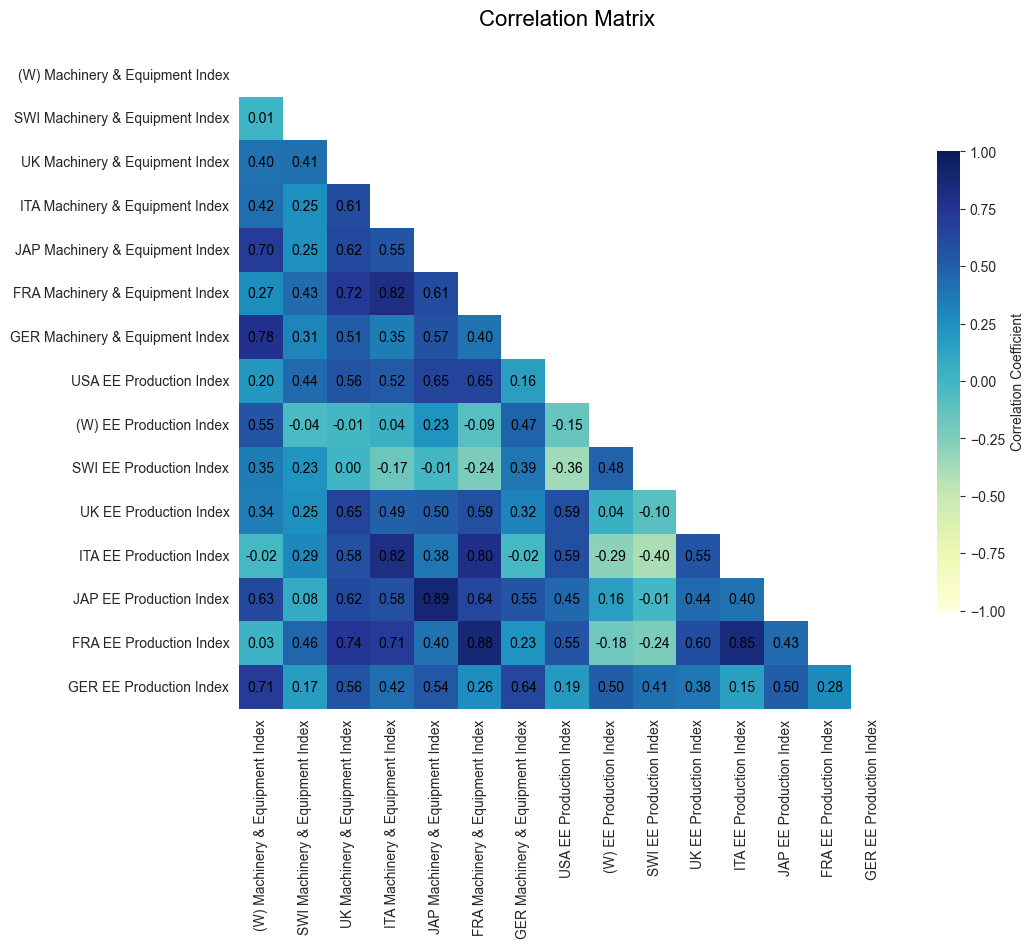

In [48]:
production_index_me_ee = market_data_resampled.iloc[:, 32:49] 
corr = np.round(production_index_me_ee.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

<br>

### 4.2.1 Germany's market

In [49]:
ger_columns = market_data_resampled.filter(like='GER', axis=1)
ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2004-02-01             82.623037            79.452532               93.230453   
2004-03-01            100.556582            97.012918               93.335678   
2004-04-01             89.653203            84.932358               93.440903   
2004-05-01             86.880571            82.372794               93.546127   
2004-06-01             99.010814            95.108740               93.440903   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2004-02-01                        80.829010                85.913200  
2004-03-01                       102.130104                97.670815  
2004-04-01                        90.961426                87.253983  
2004-05-01                        88.082901                84.675552  
2004-06-01                       100.978699                95.401802

In [50]:
# Filter the rows between 2018 and the end of the dataset
filtered_ger_columns = ger_columns[ger_columns.index.year >= 2018]
filtered_ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2018-01-01            106.597726           116.719756              107.856895   
2018-02-01            109.380540           119.492100              107.856895   
2018-03-01            125.952010           141.751327              108.172577   
2018-04-01            113.466623           126.376490              108.172577   
2018-05-01            112.104539           126.239172              108.277802   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2018-01-01                       104.548080               110.356682  
2018-02-01                       110.535408               107.262566  
2018-03-01                       130.800232               117.060593  
2018-04-01                       116.062180               108.706490  
2018-05-01                       115.025909               106.746880

In [51]:
# check the germany_market DataFrame information
filtered_ger_columns.describe()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
count             52.000000            52.000000               52.000000   
mean             109.960695           128.127577              111.345548   
std               10.389337            12.624585                2.994094   
min               81.061581            93.292777              107.856895   
25%              103.917163           120.934615              109.829885   
50%              111.392362           129.128362              110.592773   
75%              116.762521           136.899975              111.802879   
max              127.404132           151.201314              121.220627   

       GER Machinery & Equipment Index  GER EE Production Index  
count                        52.000000                52.000000  
mean                        113.101725               104.200190  
std                          12.898908                 9.280529  
min                          81.059303                81.065758  
25%                         104.346575                99.553072  
50%                         115.025909               106.179626  
75%                         122.366150               110.124624  
max                         137.363281               119.948433

In [52]:
f.resource_prices(filtered_ger_columns, filtered_ger_columns.columns)

Germany vs Europe

In [53]:
ger_columns = market_data_resampled.filter(like='GER', axis=1)
ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2004-02-01             82.623037            79.452532               93.230453   
2004-03-01            100.556582            97.012918               93.335678   
2004-04-01             89.653203            84.932358               93.440903   
2004-05-01             86.880571            82.372794               93.546127   
2004-06-01             99.010814            95.108740               93.440903   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2004-02-01                        80.829010                85.913200  
2004-03-01                       102.130104                97.670815  
2004-04-01                        90.961426                87.253983  
2004-05-01                        88.082901                84.675552  
2004-06-01                       100.978699                95.401802

In [54]:
# Filter the rows between 2018 and the end of the dataset
filtered_ger_columns = ger_columns[ger_columns.index.year >= 2018]
filtered_ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2018-01-01            106.597726           116.719756              107.856895   
2018-02-01            109.380540           119.492100              107.856895   
2018-03-01            125.952010           141.751327              108.172577   
2018-04-01            113.466623           126.376490              108.172577   
2018-05-01            112.104539           126.239172              108.277802   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2018-01-01                       104.548080               110.356682  
2018-02-01                       110.535408               107.262566  
2018-03-01                       130.800232               117.060593  
2018-04-01                       116.062180               108.706490  
2018-05-01                       115.025909               106.746880

<div class="alert-danger">

Falta copiar os gráficos que estavam no *explore*

# 5. Data Cleaning & Preprocessing

<a href="#top">Top &#129033;</a>

## 5.1 Duplicates

**Sales Data**

In [55]:
new_monthly_sales[new_monthly_sales.duplicated()]

Empty DataFrame
Columns: [#1, #3, #4, #5, #6, #8, #9, #11, #12, #13, #14, #16, #20, #36]
Index: []

**Market Data**

In [56]:
market_data[market_data.duplicated()]

Empty DataFrame
Columns: [CHI Production Index, CHI Shipments Index, FRA Production Index, FRA Shipments Index, GER Production Index, GER Shipments Index, ITA Production Index, ITA Shipments Index, JAP Production Index, JAP Shipments Index, SWI Production Index, SWI Shipments Index, UK Production Index, UK Shipments Index, USA Production Index, USA Shipments Index, Europe Production Index, Europe Shipments Index, (W) Price of Base Metals, (W) Price of Energy, (W) Price of Metals & Minerals, (W) Price of Natural gas index, (W) Price of Crude oil, average, (W) Price of Copper, USA EUR to LCU Conversion Rate , USA EE Producer Prices, UK EE Producer Prices, ITA EE Producer Prices, FRA EE Producer Prices, GER EE Producer Prices, CHI EE Producer Prices, USA Machinery & Equipment Index, (W) Machinery & Equipment Index, SWI Machinery & Equipment Index, UK Machinery & Equipment Index, ITA Machinery & Equipment Index, JAP Machinery & Equipment Index, FRA Machinery & Equipment Index, GER Machinery & Equipment Index, USA EE Production Index, (W) EE Production Index, SWI EE Production Index, UK EE Production Index, ITA EE Production Index, JAP EE Production Index, FRA EE Production Index, GER EE Production Index]
Index: []

## 5.2 Missing Values

<a href="#top">Top &#129033;</a>

### Sales Data

In [57]:
new_monthly_sales.isna().sum()

Mapped_GCK
#1     0
#3     0
#4     0
#5     0
#6     0
#8     0
#9     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#36    0
dtype: int64

In [58]:
f.missing_value_summary(new_monthly_sales)

Empty DataFrame
Columns: []
Index: []

<br>

`Missingno` Bar Plot

<Axes: xlabel='Mapped_GCK'>

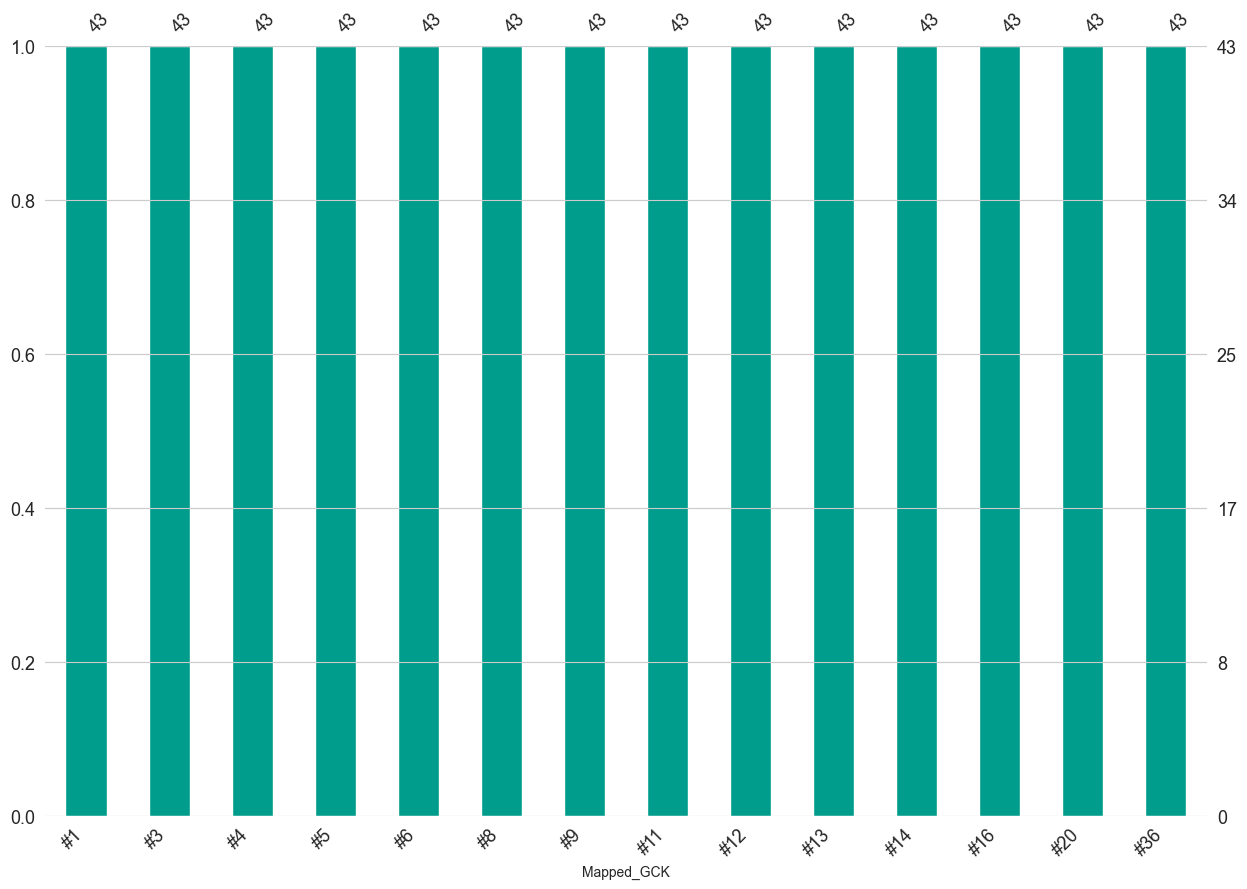

In [59]:
msno.bar(new_monthly_sales, figsize=(15,10), fontsize=13, 
         color=f.main_color, sort="ascending")

### Market Data

In [60]:
market_data.isna().sum()

CHI Production Index                0
CHI Shipments Index                 0
FRA Production Index                0
FRA Shipments Index                 0
GER Production Index                0
GER Shipments Index                 0
ITA Production Index                0
ITA Shipments Index                 0
JAP Production Index                0
JAP Shipments Index                 0
SWI Production Index                1
SWI Shipments Index                 1
UK Production Index                 0
UK Shipments Index                 18
USA Production Index                0
USA Shipments Index                 1
Europe Production Index             0
Europe Shipments Index              0
(W) Price of Base Metals            0
(W) Price of Energy                 0
(W) Price of Metals & Minerals      0
(W) Price of Natural gas index      0
(W) Price of Crude oil, average     0
(W) Price of Copper                 0
USA EUR to LCU Conversion Rate      0
USA EE Producer Prices              0
UK EE Produc

In [61]:
f.missing_value_summary(market_data)

Unique Values  NaN Values  Percentage NaN
SWI Production Index                       218           1        0.456621
SWI Shipments Index                        218           1        0.456621
UK Shipments Index                         201          18        8.219178
USA Shipments Index                        218           1        0.456621
UK EE Producer Prices                      131          18        8.219178
FRA EE Producer Prices                      79          35       15.981735
CHI EE Producer Prices                     196          23       10.502283
SWI Machinery & Equipment Index            202           1        0.456621
(W) EE Production Index                    208          11        5.022831
SWI EE Production Index                    201           1        0.456621

<br>

`Missingno` Bar Plot

<Axes: >

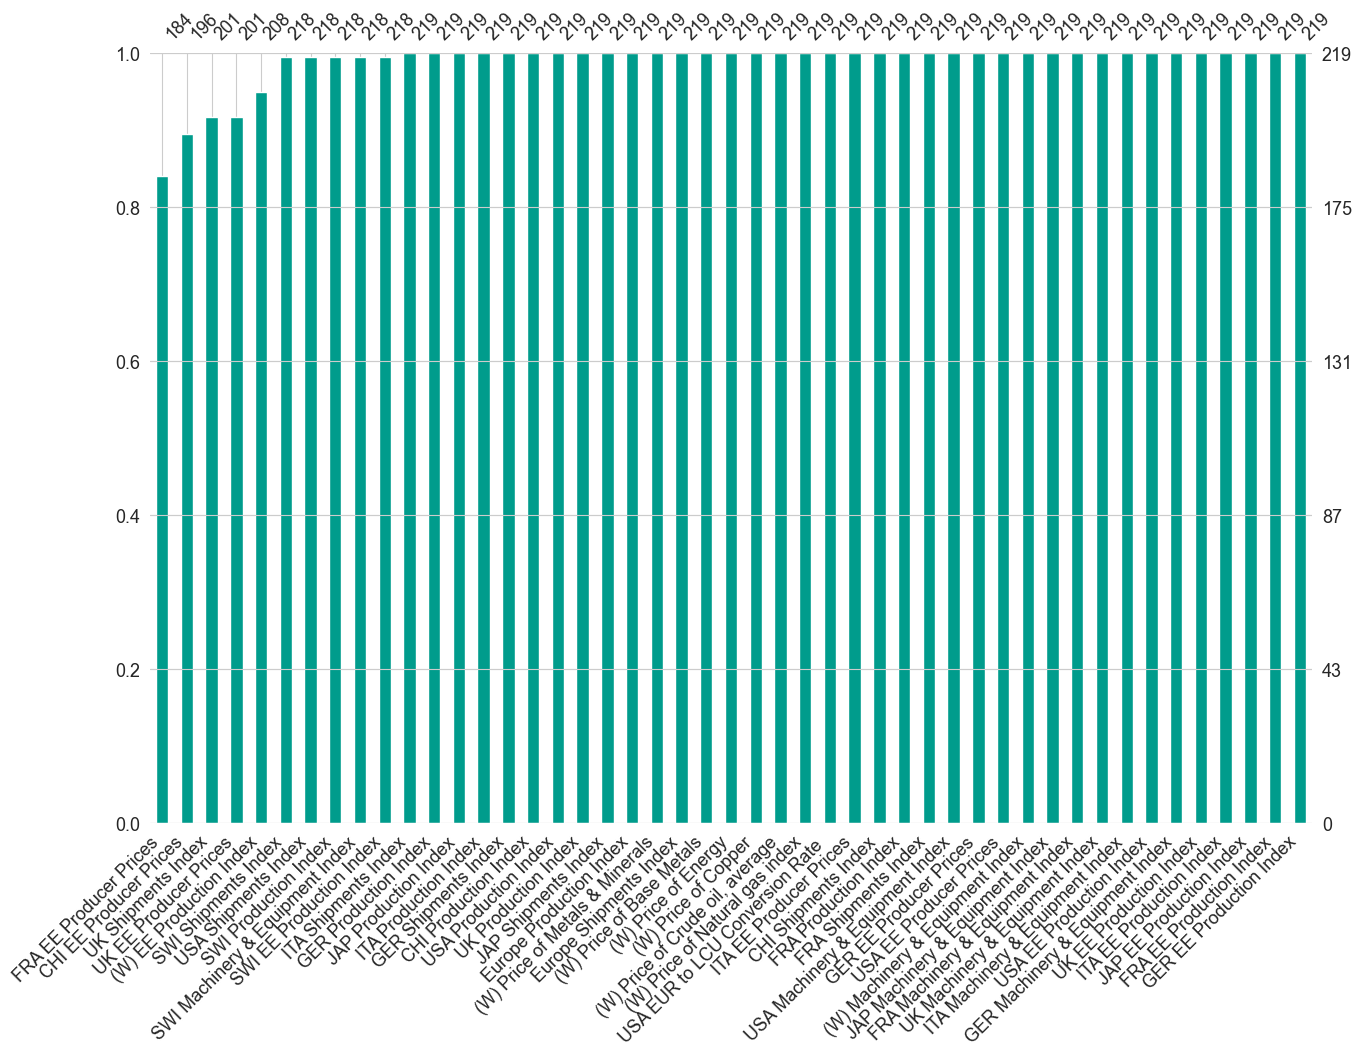

In [62]:
msno.bar(market_data, figsize=(15,10), fontsize=13, 
                 color=f.main_color, sort="ascending")

**Filling Missing values**

<div class="alert-danger">
    
TO DO - cubic fillna()

Creating a Pipeline to easily manage Scaling and Imputation

In [63]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer(n_neighbors=10))
])

Imputation

In [64]:
market_data2 = market_data.copy()

# Fit Transform
scaled_data = pipeline.named_steps['scaler'].fit_transform(market_data2)
imputed_scaled_data = pipeline.named_steps['imputer'].fit_transform(scaled_data)

In [65]:
imputed_data = scaler.inverse_transform(imputed_scaled_data)

market_data2 = pd.DataFrame(imputed_data, 
                            columns=market_data.columns, 
                            index=market_data.index)


NameError: name 'scaler' is not defined

**See how imputed values compare with real values**

Allows to visually compare different scalers and different number of neighbours

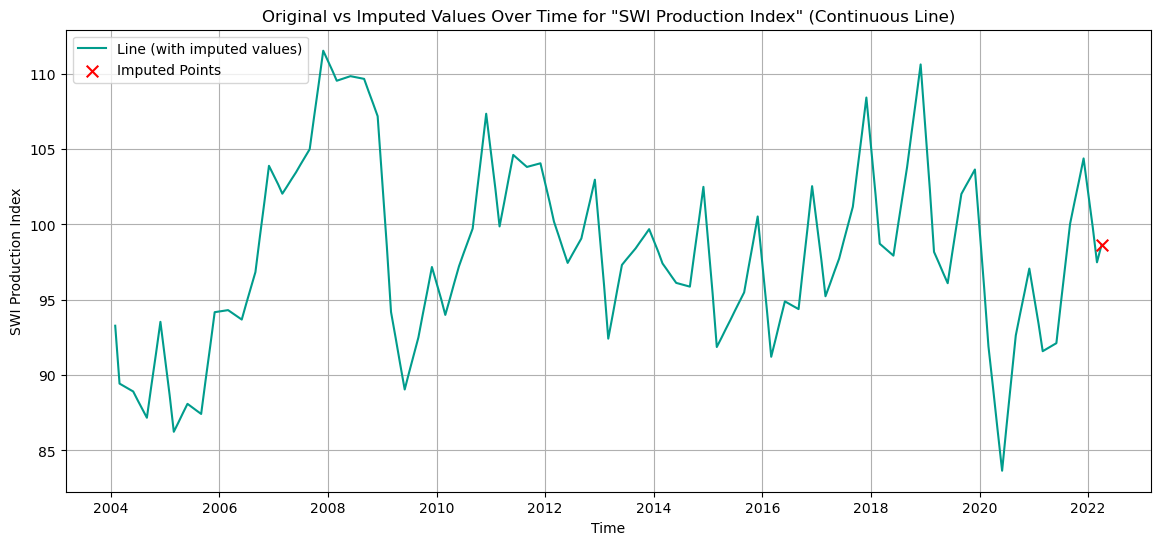

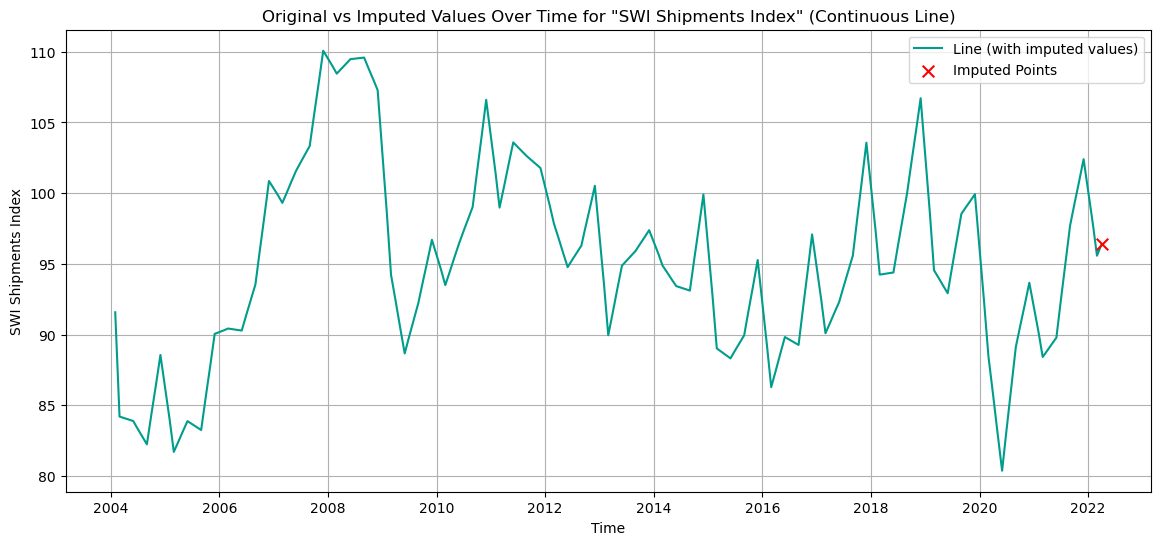

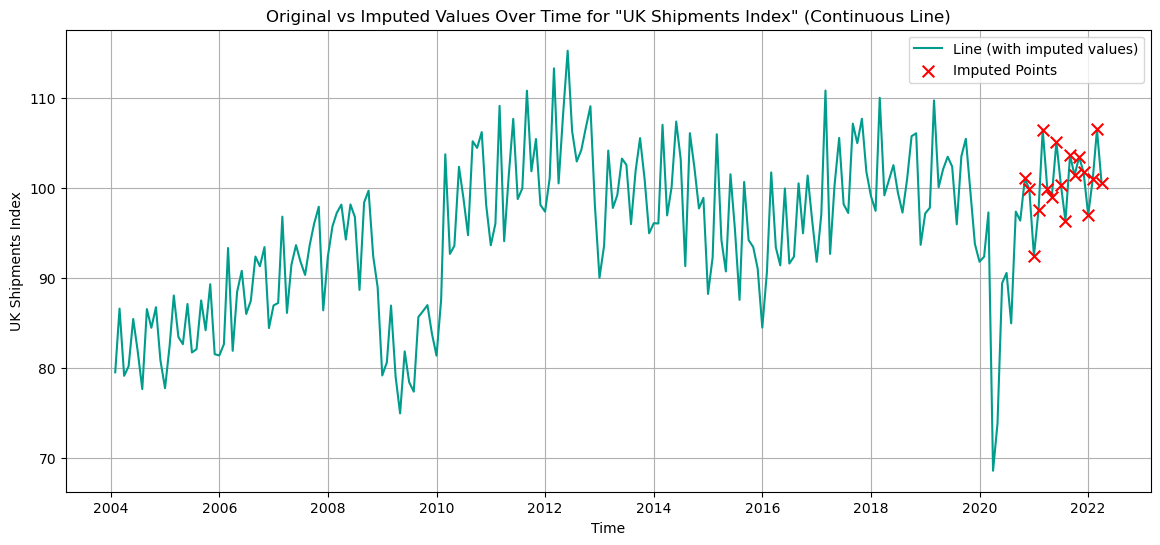

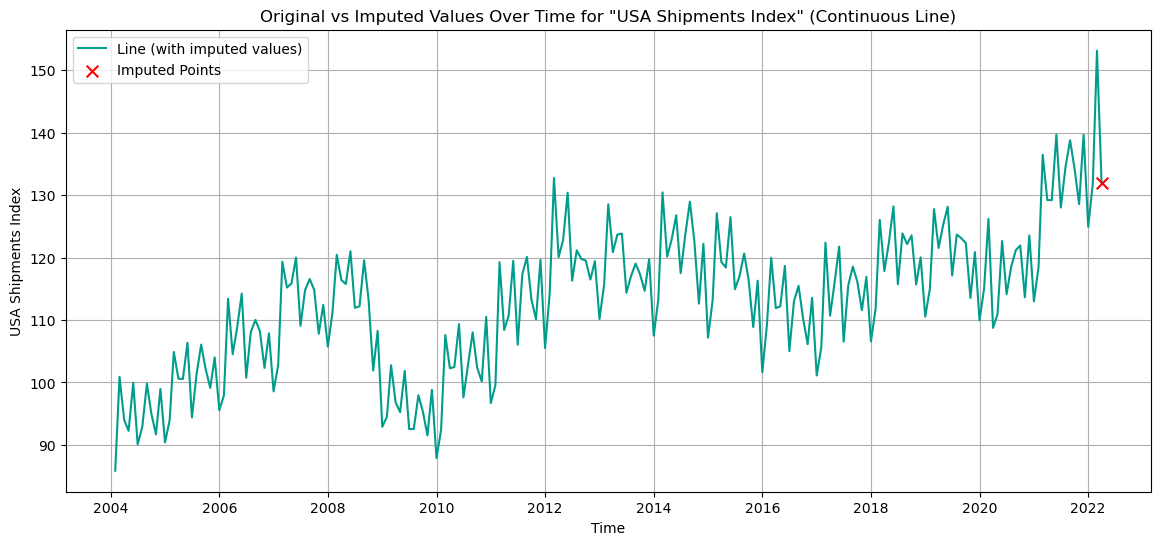

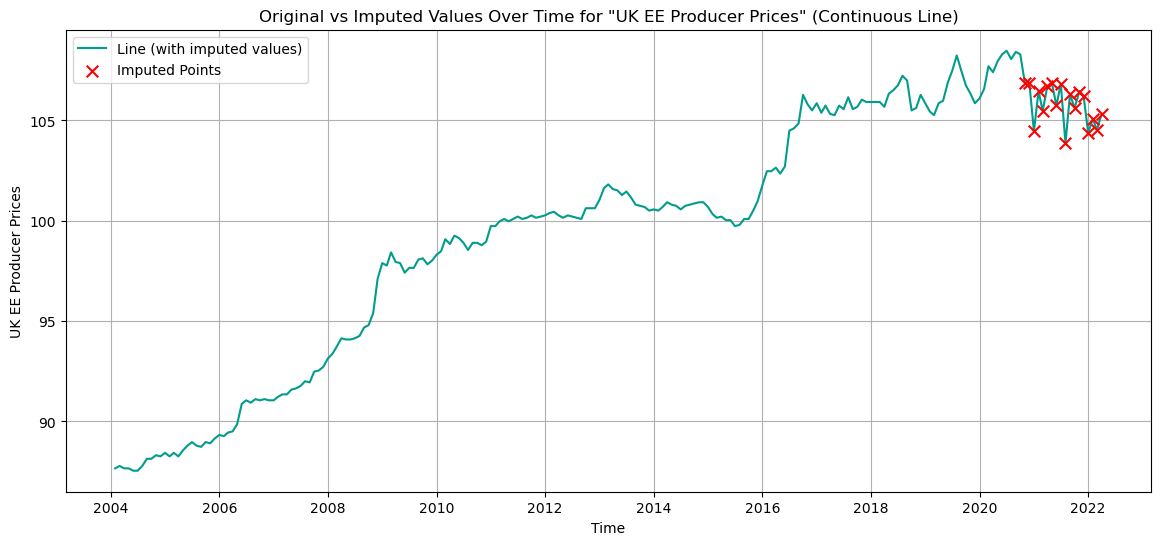

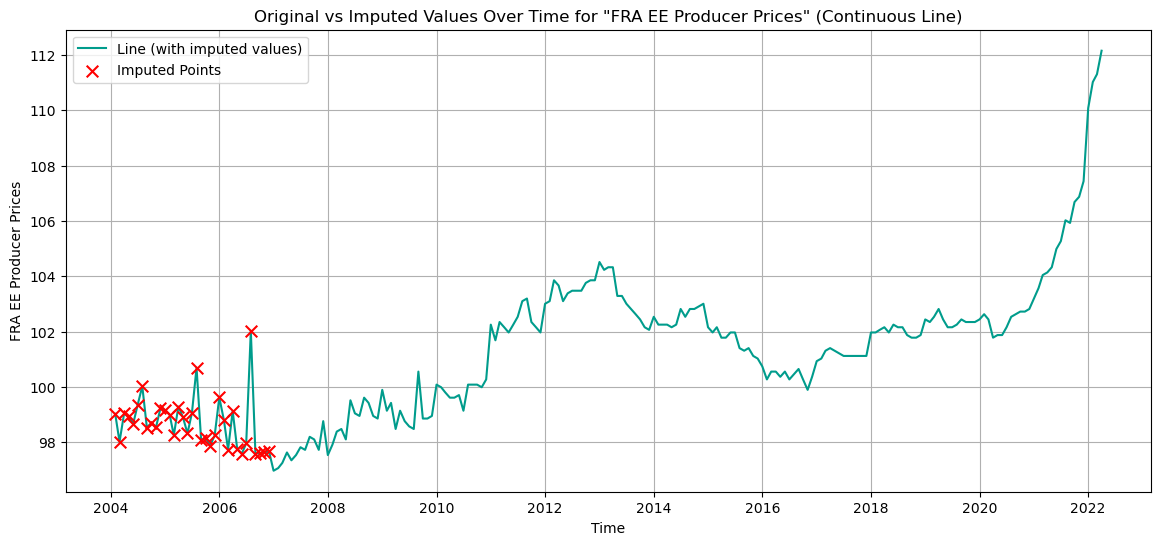

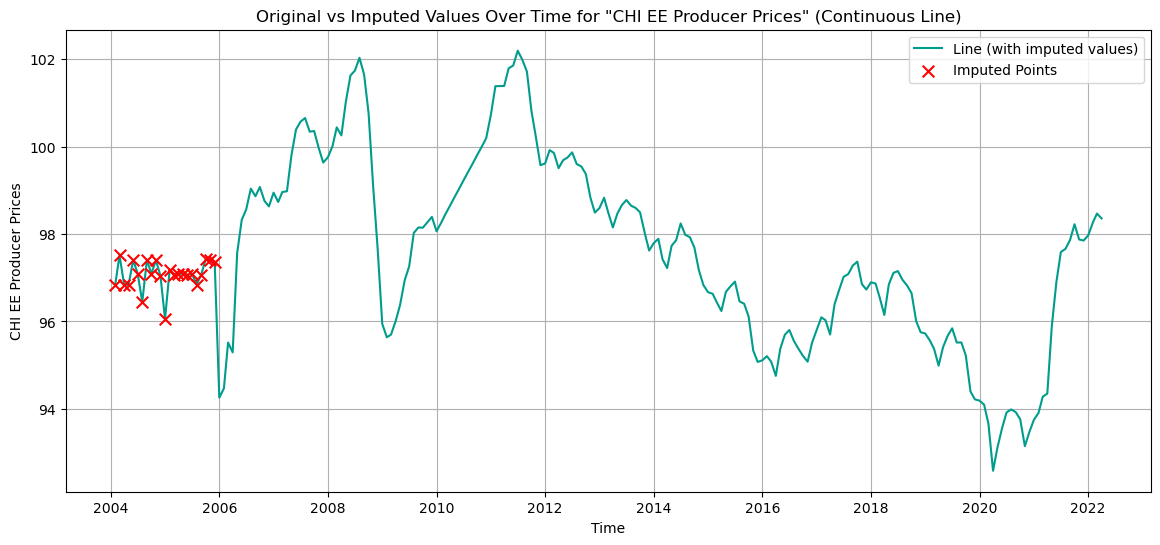

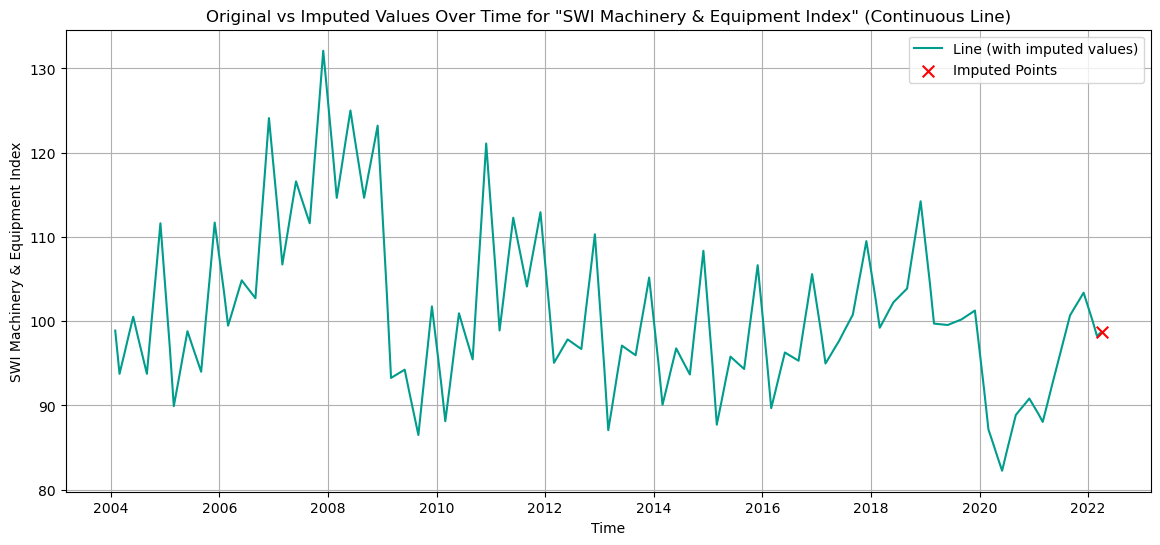

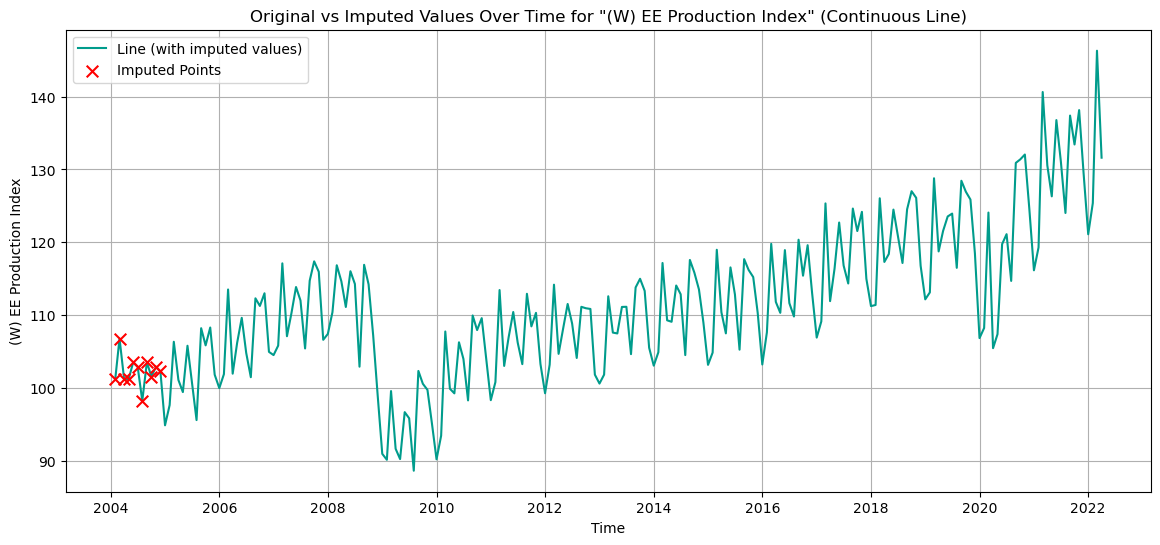

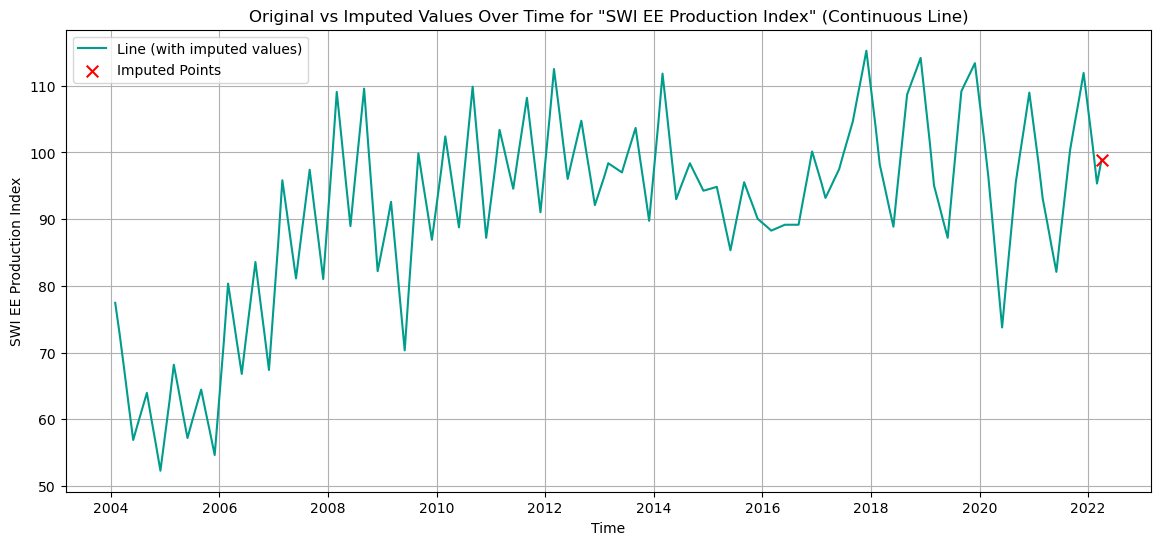

In [ ]:
cols_with_missing = market_data.columns[market_data.isna().any()]

for var in cols_with_missing:
    plt.figure(figsize=(14, 6))

    # Plot the full continuous line — including both original and imputed values
    plt.plot(market_data2.index, market_data2[var], color=f.main_color, label='Line (with imputed values)', zorder=3)

    # Highlight the imputed points on top of that line
    missing_idx = market_data[var].isna()
    plt.scatter(market_data2.index[missing_idx],
                market_data2.loc[missing_idx, var],
                color='red', label='Imputed Points', zorder=4, marker='x', s=70)

    plt.xlabel('Time')
    plt.ylabel(var)
    plt.legend()
    plt.title(f'Original vs Imputed Values Over Time for \"{var}\" (Continuous Line)')
    plt.grid(True)
    plt.show()


## 5.3 Statistical Tests

<a href="#top">Top &#129033;</a>

### Sales Data

**Augmented Dickey-Fuller Test for Stationarity**


Used to determine if a time series is stationary or if it has a unit root (non-stationary). Stationarity means that the statistical properties of the time series, such as the mean, variance, and autocorrelation, do not change over time.

- If the p-value is below a chosen significance level (0.05), reject the null hypothesis, and conclude the series is stationary.
- If the p-value is above the significance level, fail to reject the null hypothesis, and conclude the series is non-stationary.

In [ ]:
st.adf_test(new_monthly_sales, new_monthly_sales.columns)

ADF Statistic   p-value                              Critical Values  \
#1      -6.002443       0.0  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#3      -6.590291       0.0  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#4      -5.319293  0.000005  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#5      -7.636228       0.0  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#6      -3.477762  0.008577  {'1%': -3.601, '5%': -2.935, '10%': -2.606}   
#8       2.340859   0.99898  {'1%': -3.627, '5%': -2.946, '10%': -2.612}   
#9      -7.013494       0.0  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#11     -5.577923  0.000001  {'1%': -3.601, '5%': -2.935, '10%': -2.606}   
#12     -3.869337  0.002272  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#13     -3.254199  0.017054  {'1%': -3.606, '5%': -2.937, '10%': -2.607}   
#14     -6.871822       0.0  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#16     -6.367204       0.0  {'1%': -3.646, '5%': -2.954, '10%': -2.616}   
#20     -3.125179  0.024745  {'1%': -3.601, '5%': -2.935, '10%': -2.606}   
#36     -7.000027       0.0  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   

    Stationary  
#1         Yes  
#3         Yes  
#4         Yes  
#5         Yes  
#6         Yes  
#8          No  
#9         Yes  
#11        Yes  
#12        Yes  
#13        Yes  
#14        Yes  
#16        Yes  
#20        Yes  
#36        Yes

#8 is non-stationary --> try differencing

In [ ]:
new_monthly_sales['diff_#8'] = new_monthly_sales['#8'].diff().fillna(method='bfill')

# fill c/ 0 fica bue diferente do resto dos numeros
# fill com ffill mantém 1 Nan

In [ ]:
st.adf_test(new_monthly_sales, ['diff_#8'])

ADF Statistic   p-value                             Critical Values  \
diff_#8     -4.856417  0.000042  {'1%': -3.621, '5%': -2.944, '10%': -2.61}   

        Stationary  
diff_#8        Yes

**Seasonality Decomposition - STL**

In [ ]:
cols = ['#1']
st.stl_decomposition(new_monthly_sales, cols)

## 5.4 Feature Engineering

<a href="#top">Top &#129033;</a>

### Sales Data

<div class="alert-danger">
    
## Should I create Lag features?

In [ ]:
# Extract Year and Month from DateTimeIndex
new_monthly_sales['Year'] = new_monthly_sales.index.year
new_monthly_sales['Month'] = new_monthly_sales.index.month

In [ ]:
# Create Semester and Quarter columns
new_monthly_sales['Semester'] = new_monthly_sales['Month'].apply(f.get_semester)
new_monthly_sales['Quarter'] = new_monthly_sales['Month'].apply(f.get_quarter)

In [81]:
# Create a cyclical feature for Month
new_monthly_sales['sin_month'] = np.sin(2 * np.pi * new_monthly_sales['Month'] / 12)
new_monthly_sales['cos_month'] = np.cos(2 * np.pi * new_monthly_sales['Month'] / 12)

In [ ]:
# Apply the function to get both weekend days and total days in the month
new_monthly_sales[['WeekendDaysCount', 'TotalDaysInMonth']] = new_monthly_sales.apply(
    lambda row: pd.Series(f.count_weekends_in_month(int(row['Year']), int(row['Month']))), axis=1)

# Calculate the percentage of weekend days in the month
new_monthly_sales['WeekendDaysPercentage'] = (new_monthly_sales['WeekendDaysCount'] / new_monthly_sales['TotalDaysInMonth']) * 100

In [ ]:
new_monthly_sales['SundayCount'] = new_monthly_sales.apply(lambda row: f.count_sundays_in_month(int(row['Year']), int(row['Month'])), axis=1)

In [ ]:
new_monthly_sales['GerHolidayCount'] = new_monthly_sales.apply(lambda row: f.count_holidays_in_month(new_monthly_sales, int(row['Year']), int(row['Month'])), axis=1)

### Market Data

**Rolling Mean**

In [ ]:
for col in market_data2.columns:
    col_name = f'{col}_Rolling_Mean_3'
    market_data2[col_name] = market_data2[col].rolling(window=3).mean()
    market_data2[col_name].fillna(method='bfill', inplace=True)
    

In [ ]:
market_data2

CHI Production Index  CHI Shipments Index  FRA Production Index  \
Date                                                                          
2004-02-01             67.731107            67.731107            113.054762   
2004-03-01             71.830527            71.830527            135.395289   
2004-04-01             72.268481            72.268481            118.309310   
2004-05-01             71.828265            71.828265            110.207679   
2004-06-01             73.826785            73.826785            133.051944   
...                          ...                  ...                   ...   
2021-12-01            245.618486           245.618486            102.430941   
2022-01-01            200.328450           200.328450             88.768328   
2022-02-01            200.328450           200.328450             93.248137   
2022-03-01            256.909768           256.909768            109.139360   
2022-04-01            219.349087           219.349087             90.570015   

            FRA Shipments Index  GER Production Index  GER Shipments Index  \
Date                                                                         
2004-02-01            88.979484             86.933861            87.873122   
2004-03-01           105.429837            100.920154           100.369702   
2004-04-01            95.172114             92.416657            91.772756   
2004-05-01            90.600388             90.254293            89.951282   
2004-06-01           105.772683             99.714616            99.014623   
...                         ...                   ...                  ...   
2021-12-01           126.017883            114.604748           137.624751   
2022-01-01           106.870013             96.236123           116.979600   
2022-02-01           113.794759            103.596237           123.405855   
2022-03-01           127.661674            117.104187           138.932043   
2022-04-01           112.934888            100.113448           121.725823   

            ITA Production Index  ITA Shipments Index  JAP Production Index  \
Date                                                                          
2004-02-01            125.071908            88.098556            109.892879   
2004-03-01            144.833738           104.607789            137.498146   
2004-04-01            130.026535            95.624808            106.847669   
2004-05-01            136.750789            99.386078            103.357659   
2004-06-01            137.613255           108.400609            119.516398   
...                          ...                  ...                   ...   
2021-12-01             93.775954           141.439863            126.025005   
2022-01-01             86.380722           100.363443            110.878225   
2022-02-01            106.773675           116.801086            117.369888   
2022-03-01            125.431927           144.078803            147.224066   
2022-04-01            103.645330           123.290578            114.204921   

            JAP Shipments Index  SWI Production Index  SWI Shipments Index  \
Date                                                                         
2004-02-01           110.707391             93.280214            91.581756   
2004-03-01           142.640444             89.439872            84.208801   
2004-04-01           103.385580             89.265064            84.104609   
2004-05-01           101.190313             89.090257            84.000418   
2004-06-01           119.226174             88.915449            83.896226   
...                         ...                   ...                  ...   
2021-12-01           129.885804            104.382070           102.405032   
2022-01-01           111.013974            102.084014           100.130016   
2022-02-01           117.996940             99.785959            97.855000   
2022-03-01           153.581332             97.487903            95.579983   
2022-

## 5.5 Outliers

<a href="#top">Top &#129033;</a>

### Sales Data

**ADF, Autocorrelation and Partial Autocorrelation**

Useful to visually identify outliers

Results for #1: | ADF Statistic: -6.002443 | p-value: 0.000000


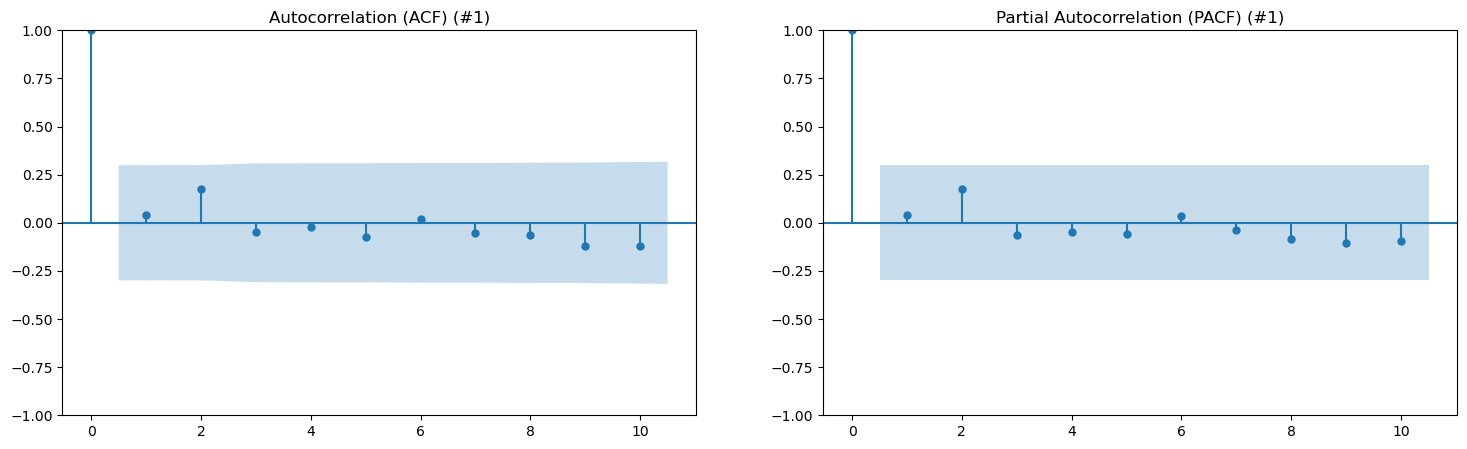

Results for #3: | ADF Statistic: -6.590291 | p-value: 0.000000


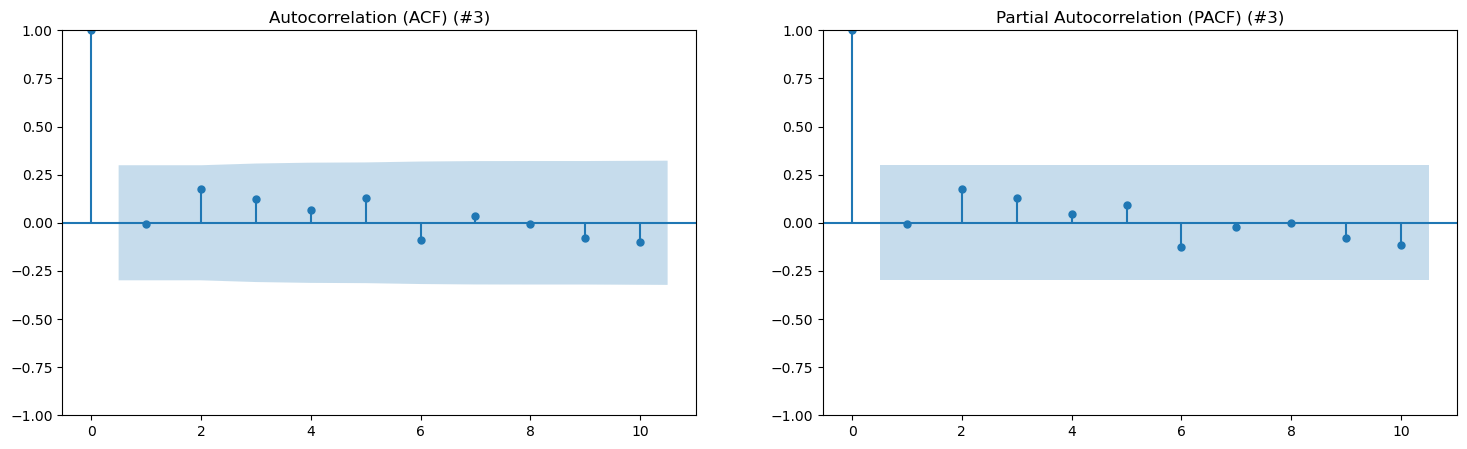

Results for #4: | ADF Statistic: -5.319293 | p-value: 0.000005


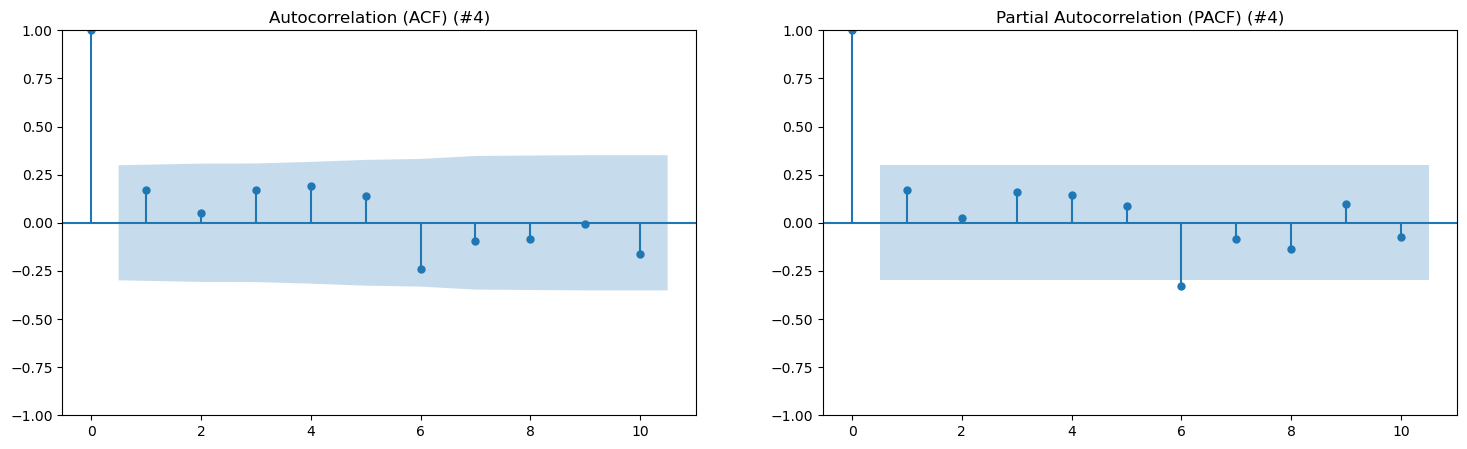

Results for #5: | ADF Statistic: -7.636228 | p-value: 0.000000


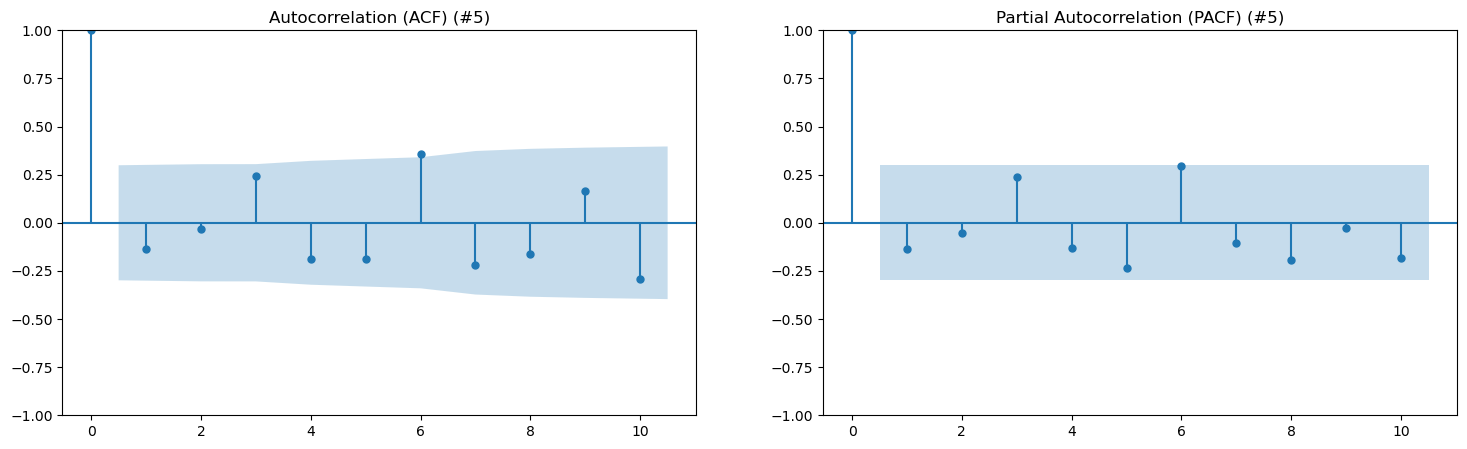

Results for #6: | ADF Statistic: -3.477762 | p-value: 0.008577


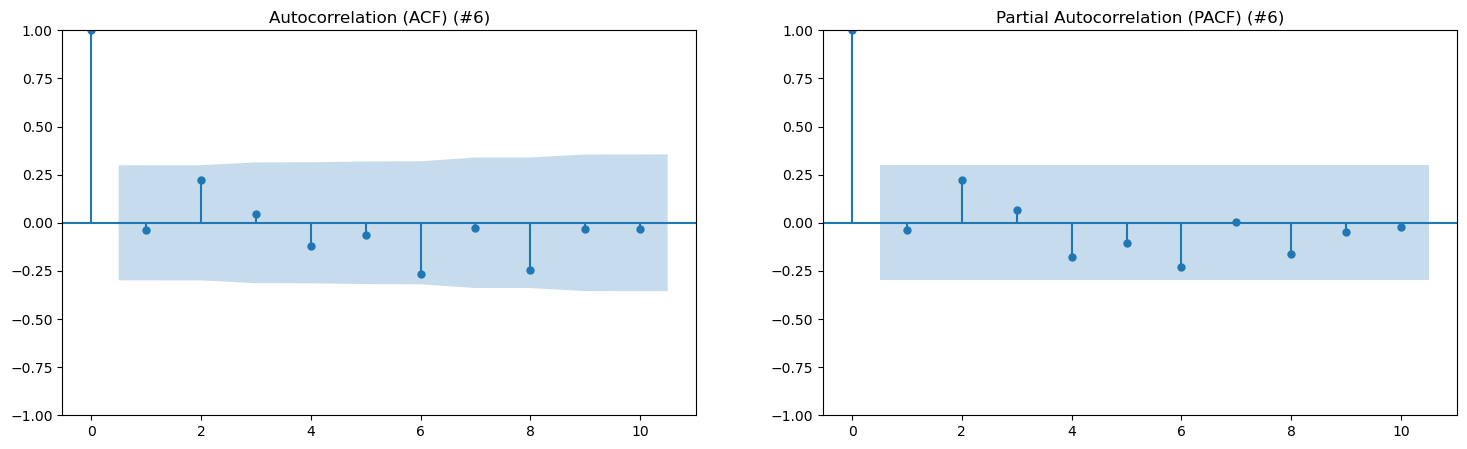

Results for #8: | ADF Statistic: 2.340859 | p-value: 0.998980


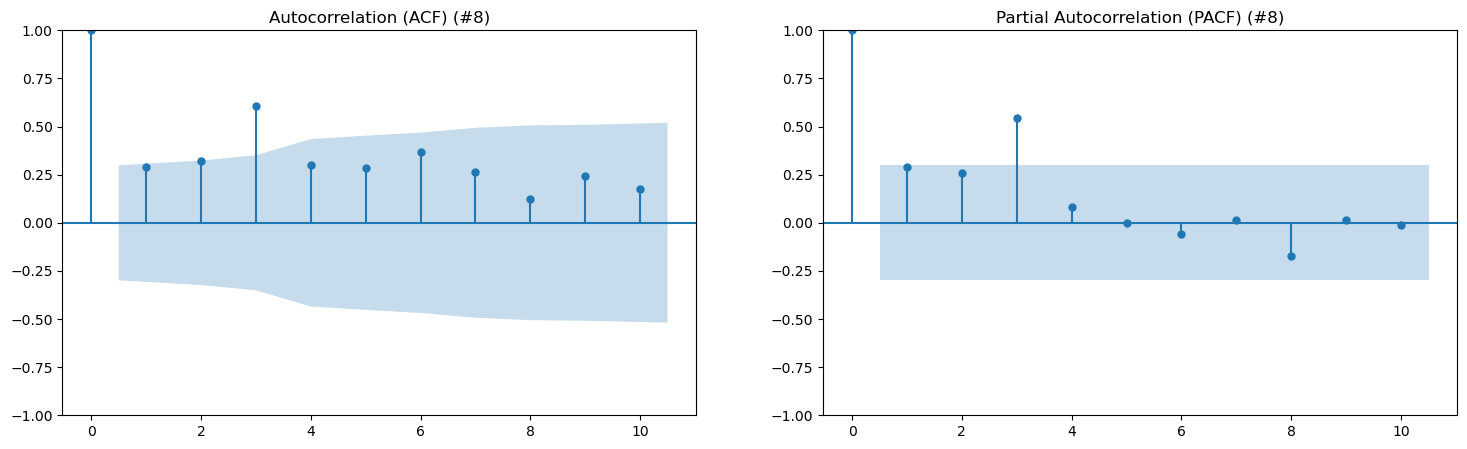

Results for #9: | ADF Statistic: -7.013494 | p-value: 0.000000


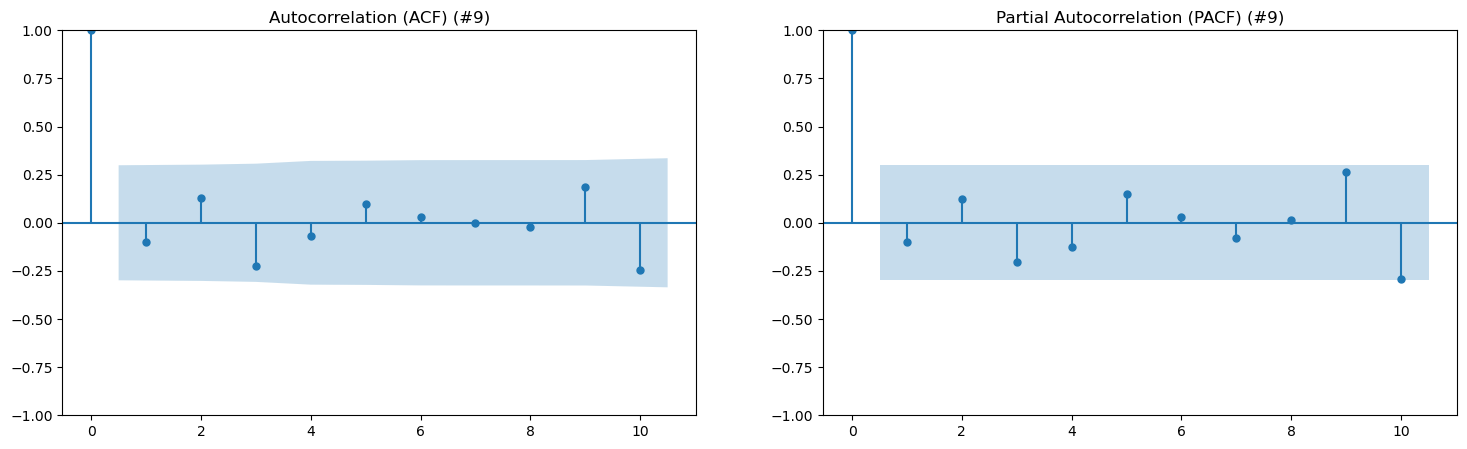

Results for #11: | ADF Statistic: -5.577923 | p-value: 0.000001


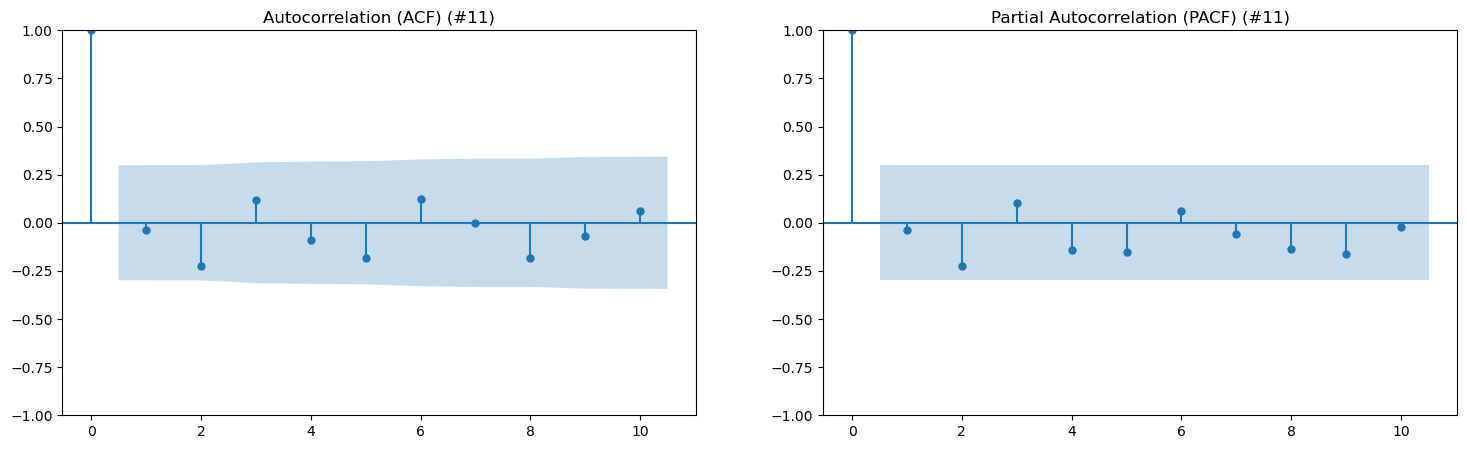

Results for #12: | ADF Statistic: -3.869337 | p-value: 0.002272


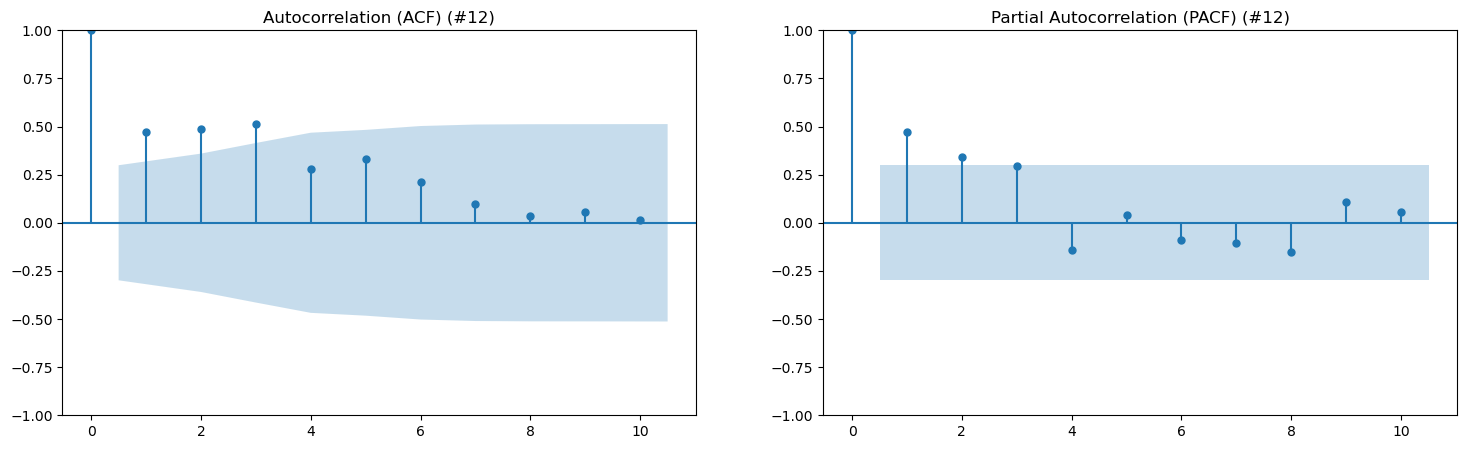

Results for #13: | ADF Statistic: -3.254199 | p-value: 0.017054


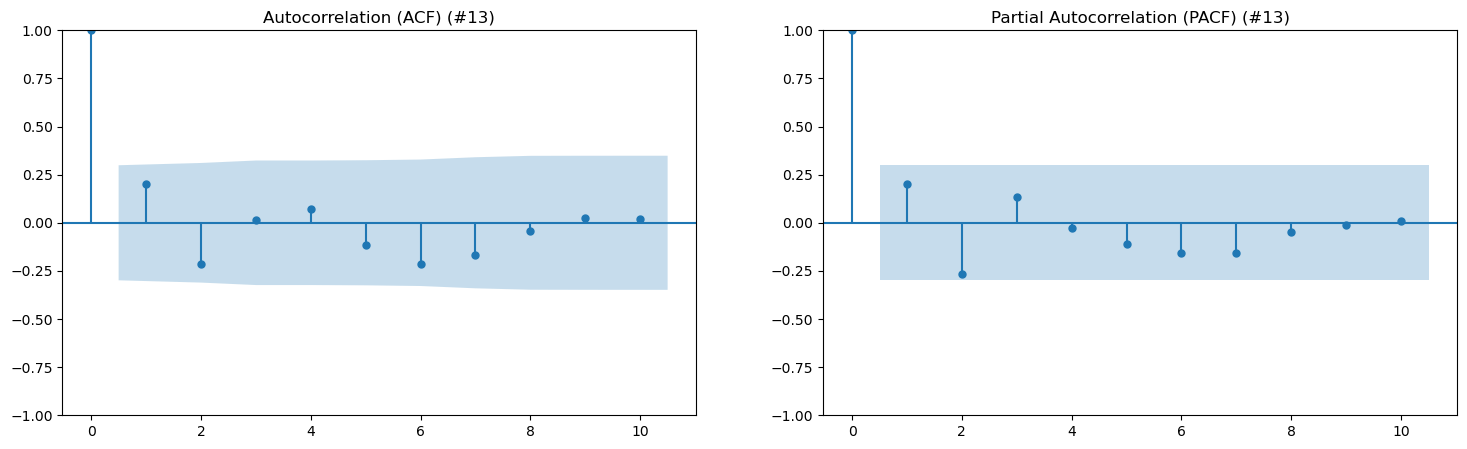

Results for #14: | ADF Statistic: -6.871822 | p-value: 0.000000


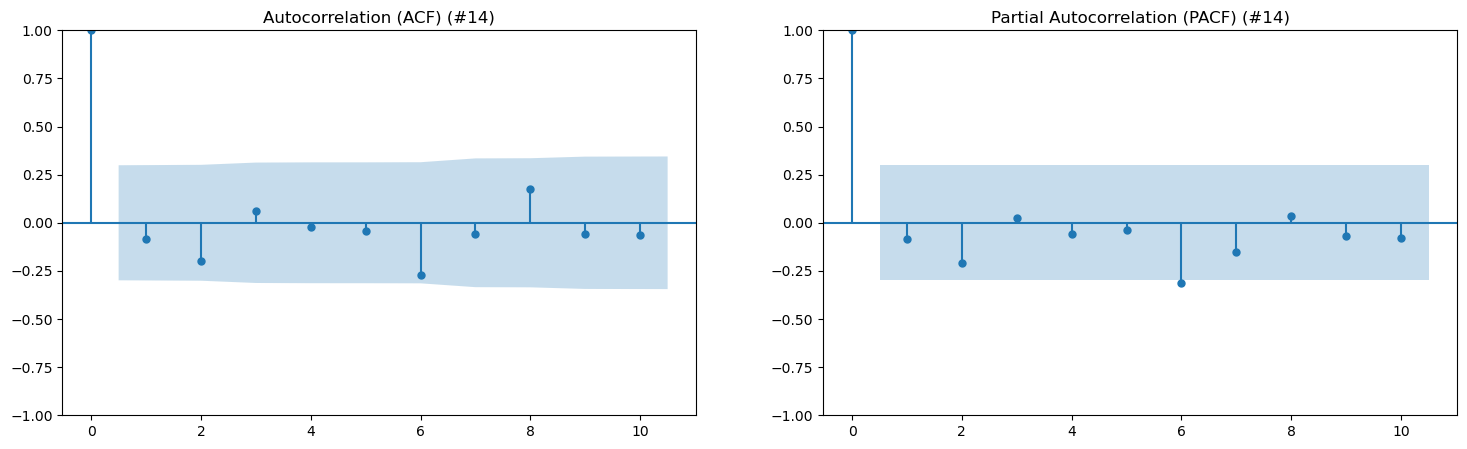

Results for #16: | ADF Statistic: -6.367204 | p-value: 0.000000


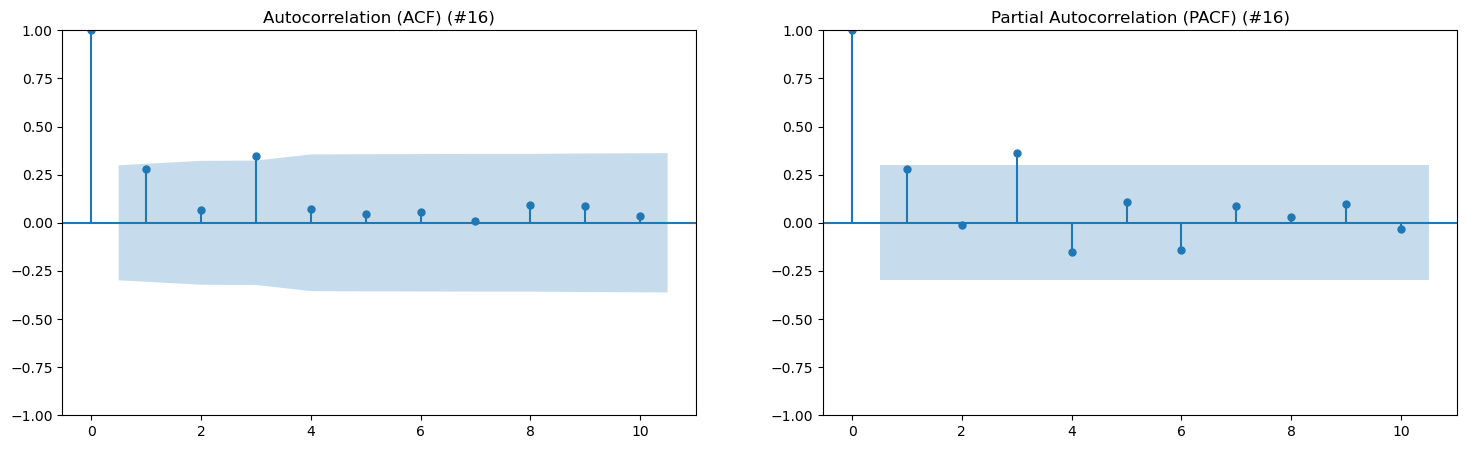

Results for #20: | ADF Statistic: -3.125179 | p-value: 0.024745


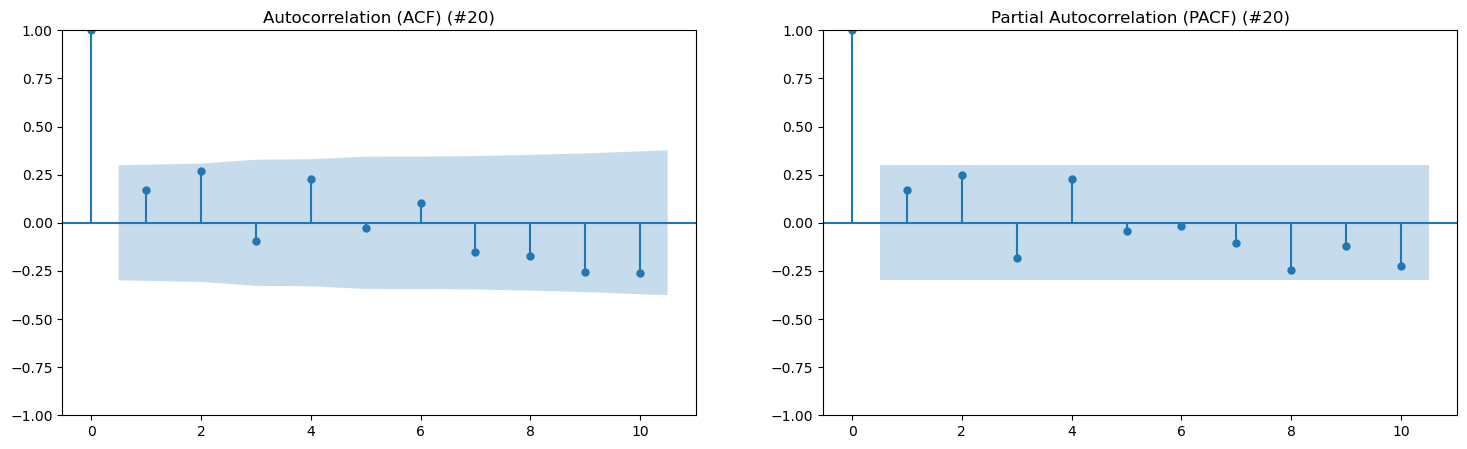

Results for #36: | ADF Statistic: -7.000027 | p-value: 0.000000


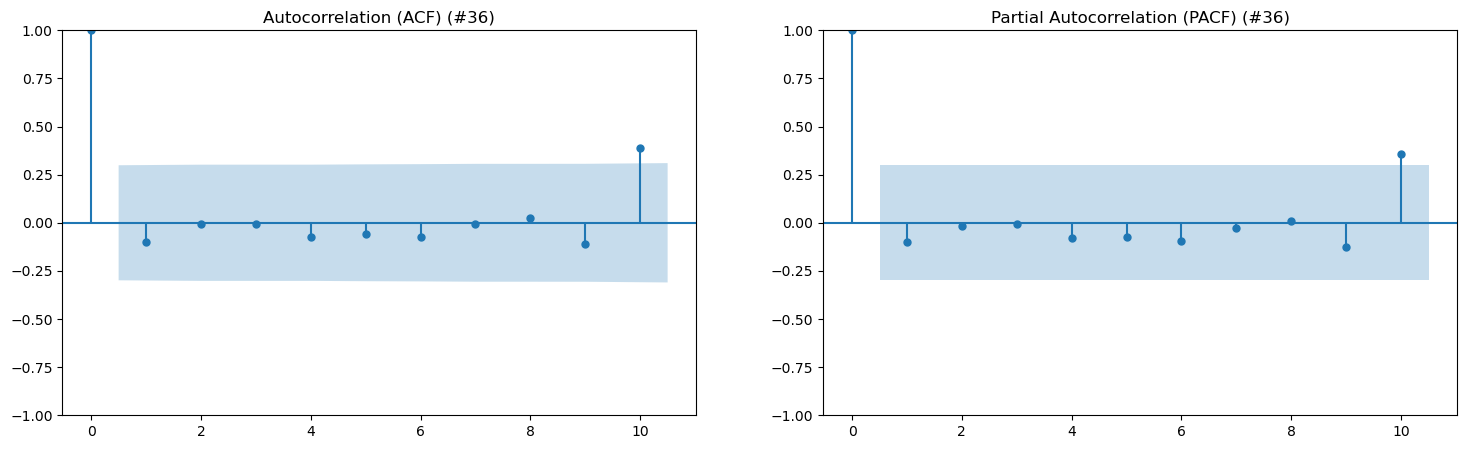

Results for diff_#8: | ADF Statistic: -4.856417 | p-value: 0.000042


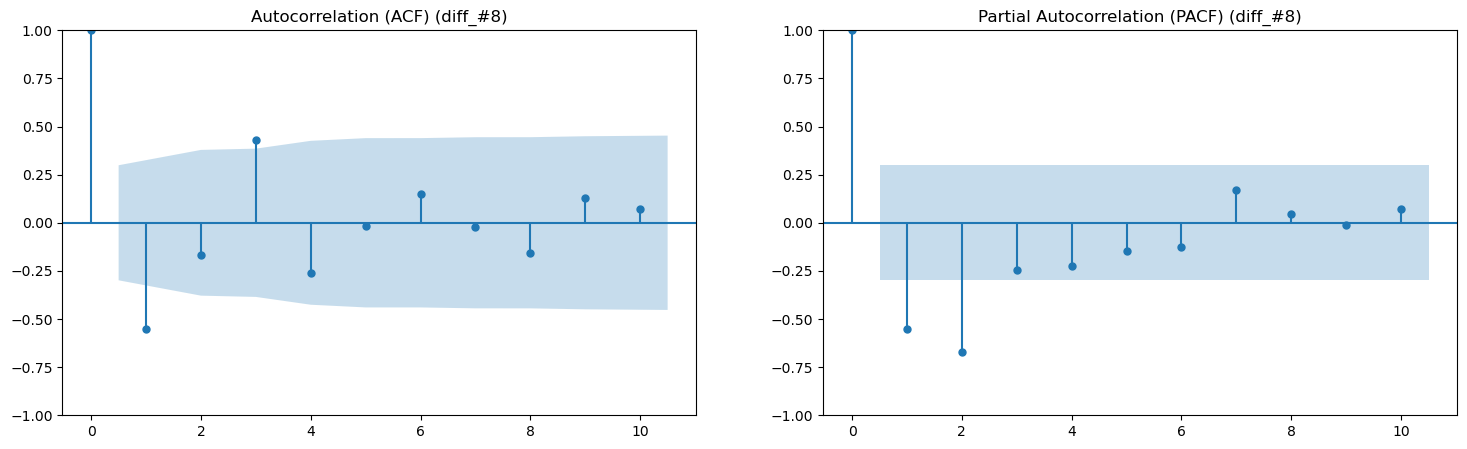

In [ ]:
st.outliers_stationarity(new_monthly_sales)

| Column | Outliers |
| ------ | -------- |
| #1 | 2018-11 |
| #3 | 2021-01 |
| #4 | - |
| #5 | 2021-01, 2021-08 |
| #6 | - |
| #8 | - |
| #8_diff | - |
| #9 | 2020-10, 2020-11 |
| #11 | - |
| #12 | - |
| #13 | - |
| #14 | 2021-07 |
| #16 | 2018-12, 2019-3 |
| #20 | - |
| #36 | 2020-06, 2021-04 |




**Boxplots**

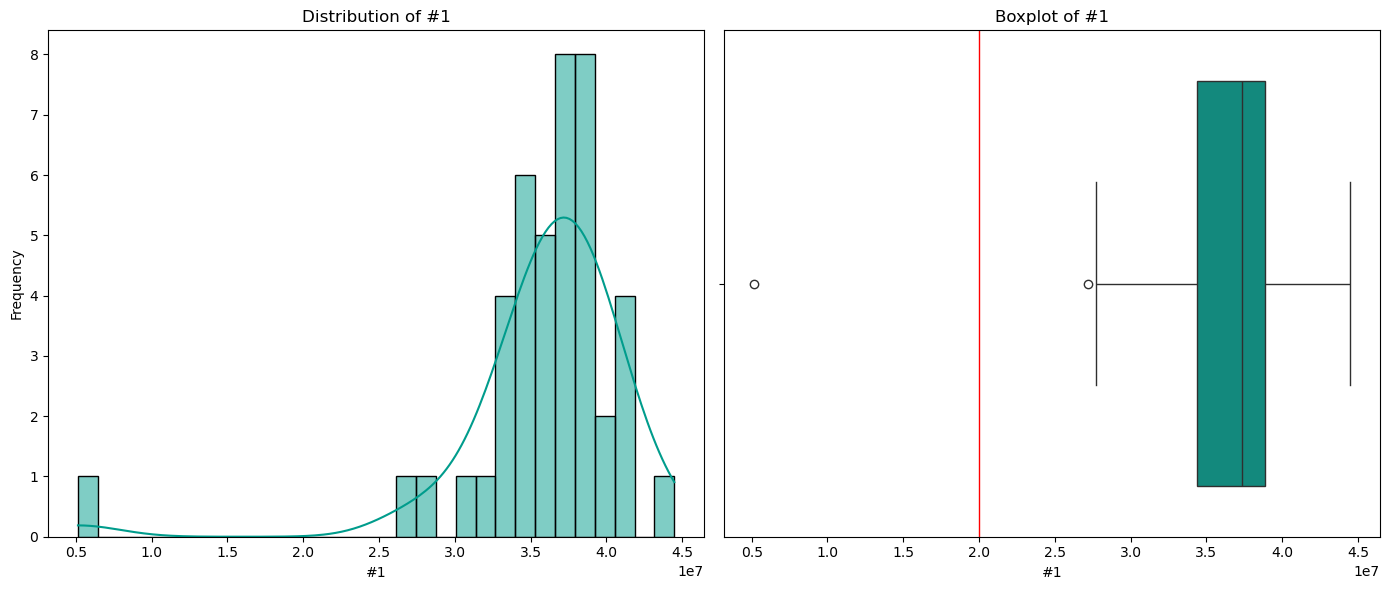

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[0], 
                              n_bins=30,
                             out_left = 20000000)

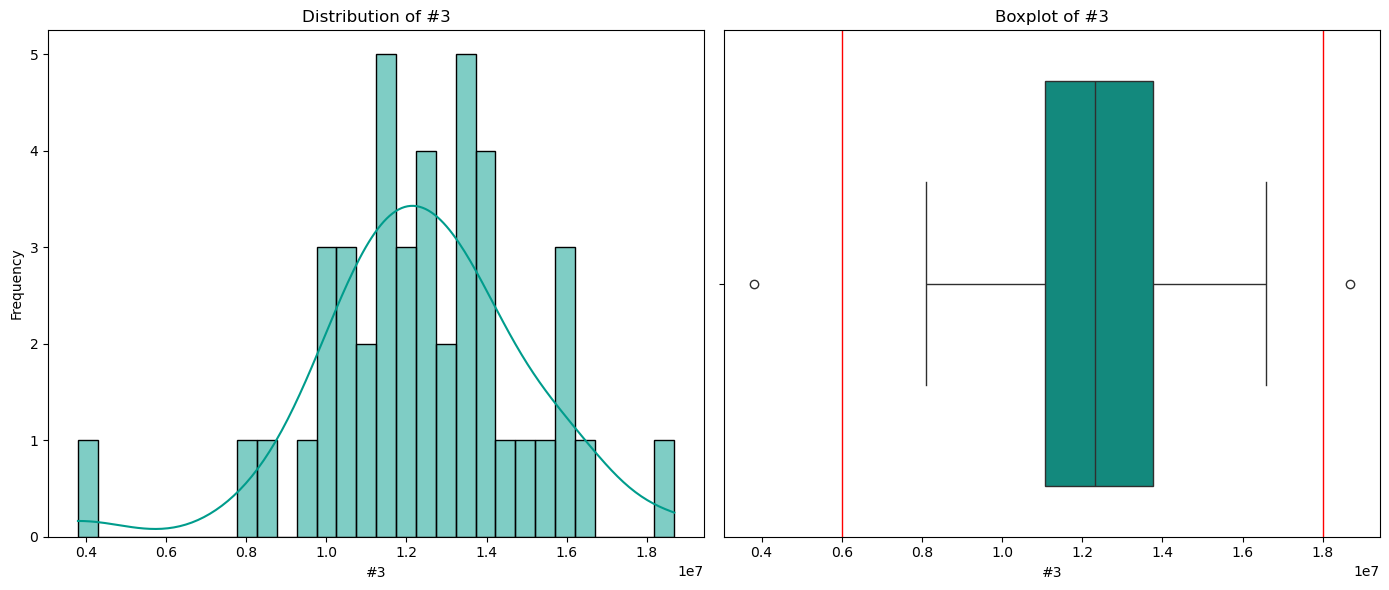

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[1], 
                              n_bins=30,
                              out_left = 6000000,
                              out_right = 18000000)

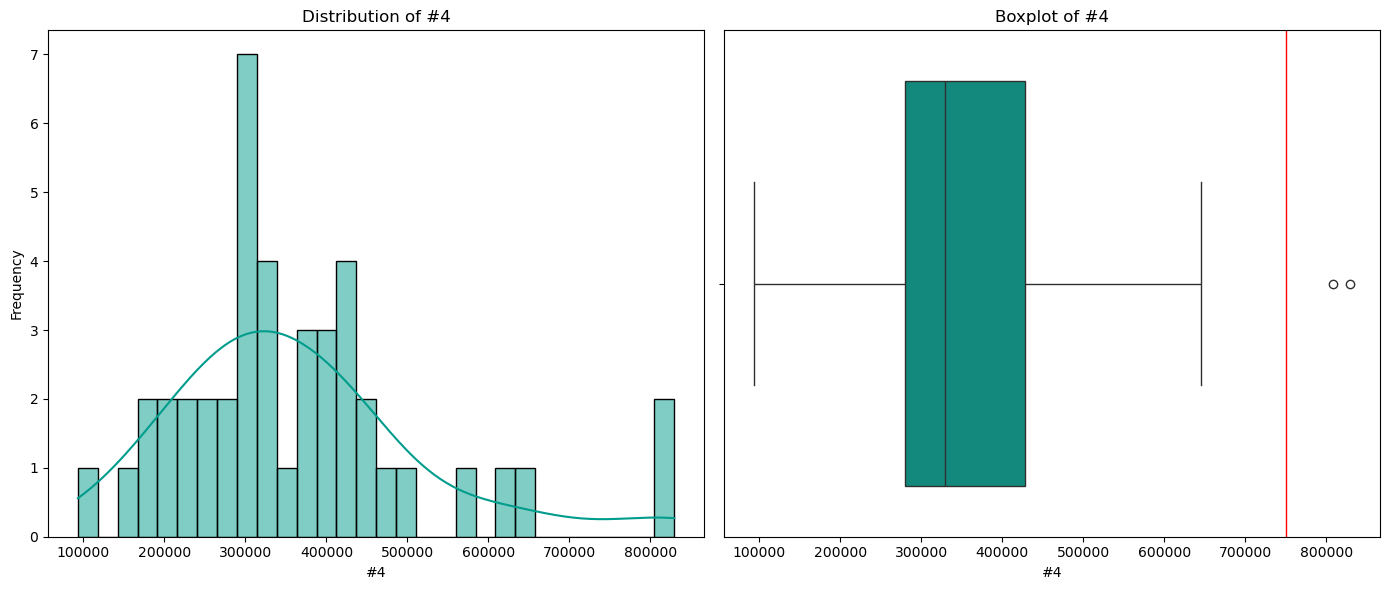

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[2], 
                              n_bins=30,
                              out_right = 750000)

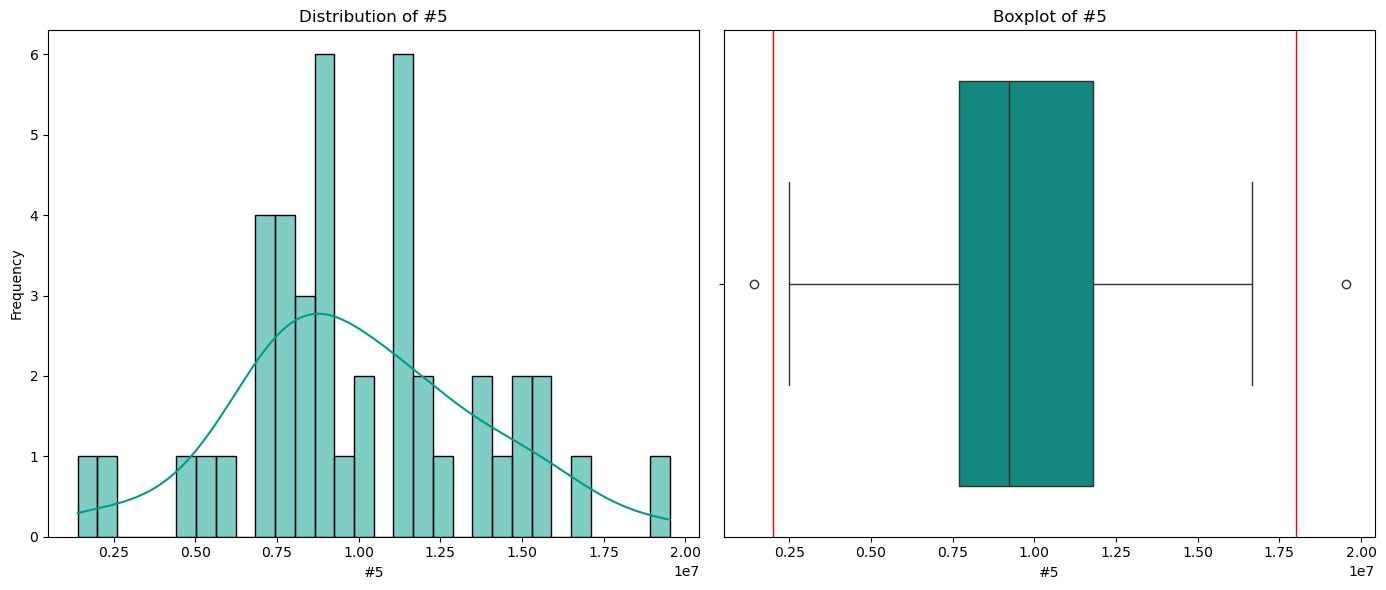

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[3], 
                              n_bins=30,
                              out_left = 2000000,
                              out_right = 18000000)

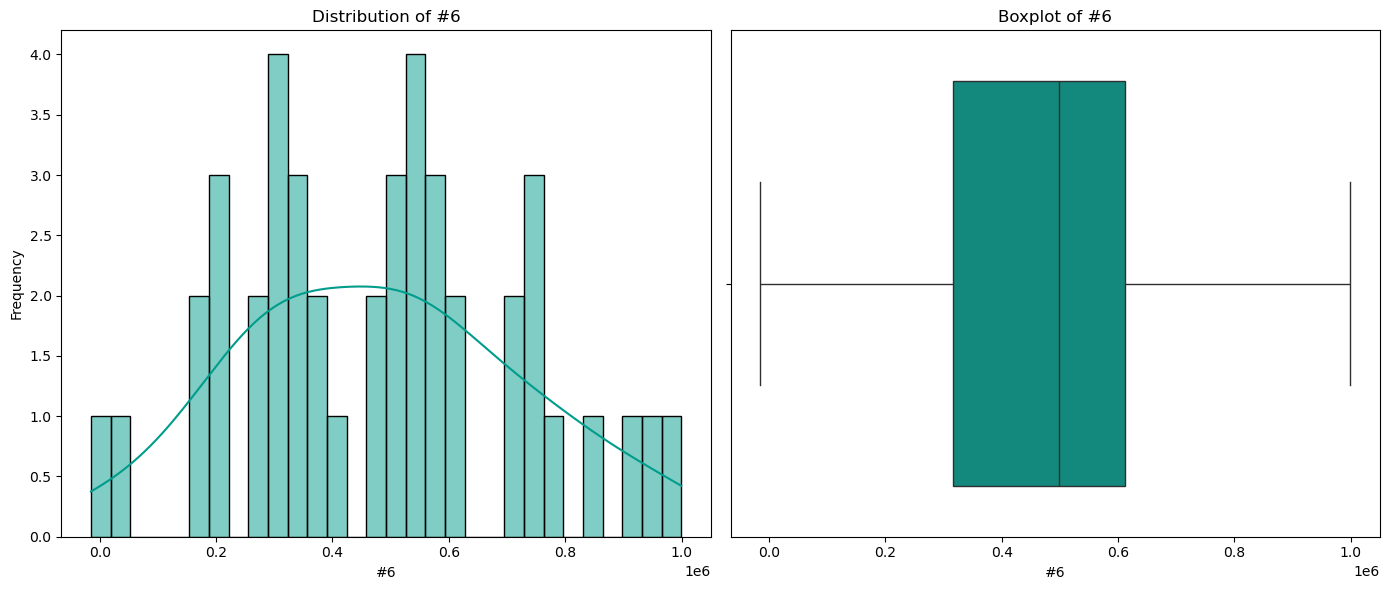

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[4], 
                              n_bins=30)

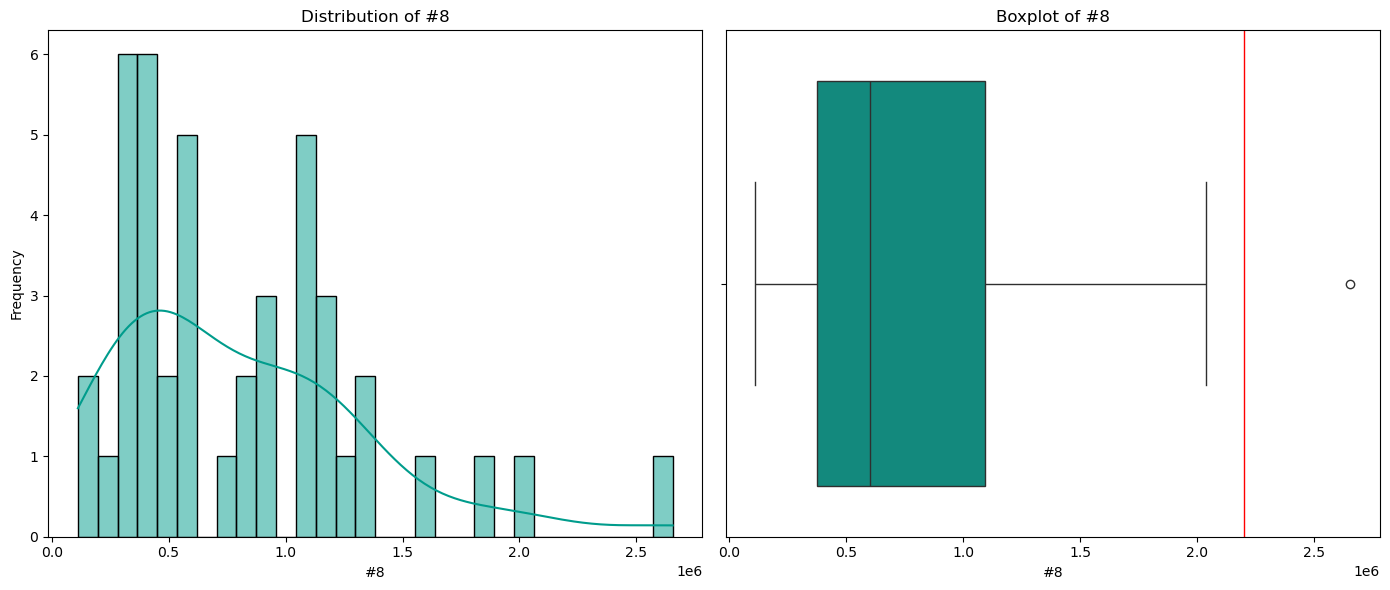

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[5], 
                              n_bins=30,
                              out_right = 2200000)

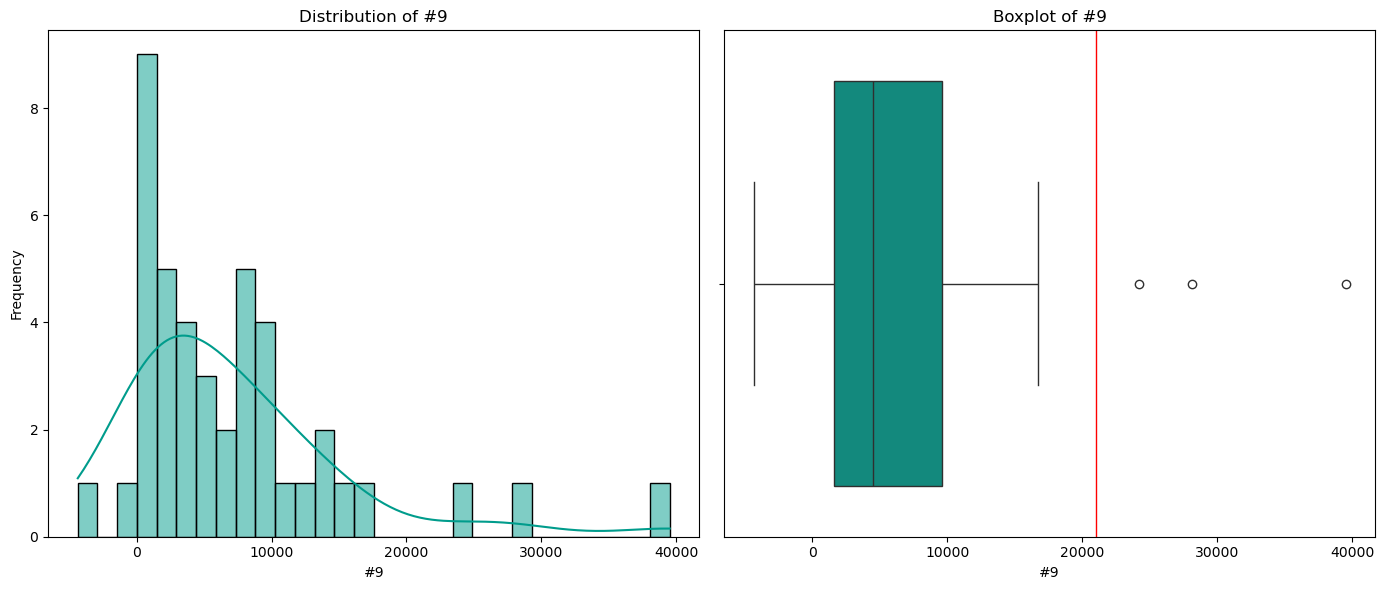

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[6], 
                              n_bins=30,
                              out_right = 21000)

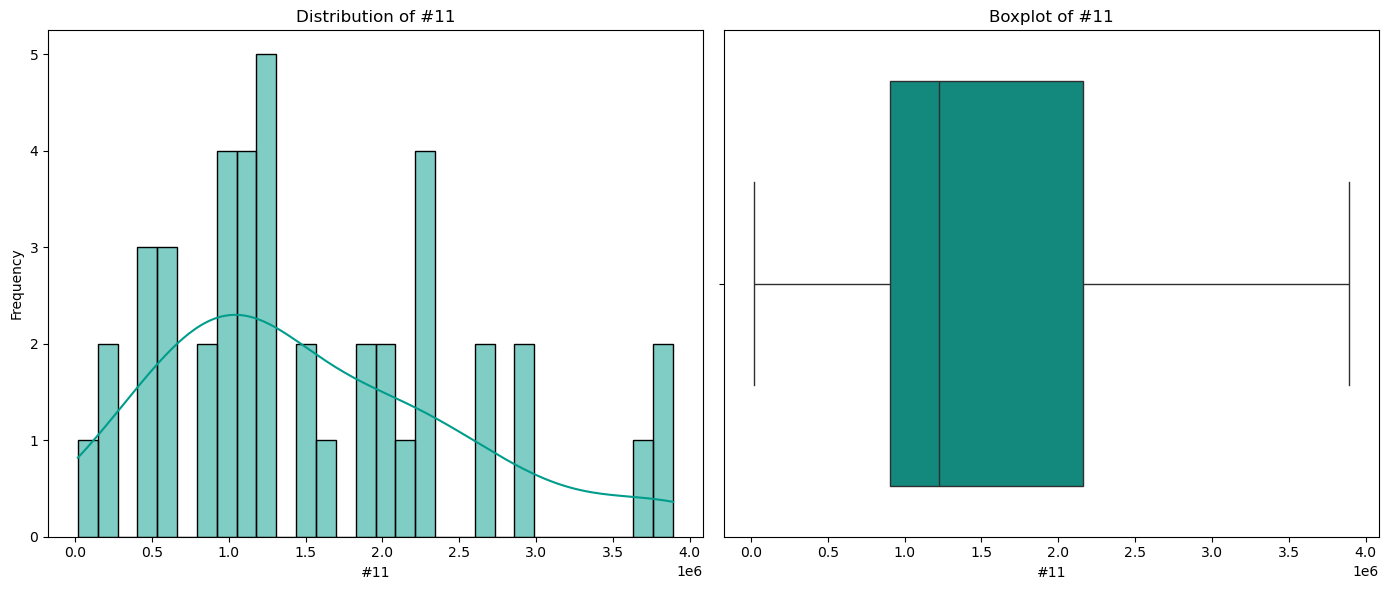

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[7], 
                              n_bins=30)

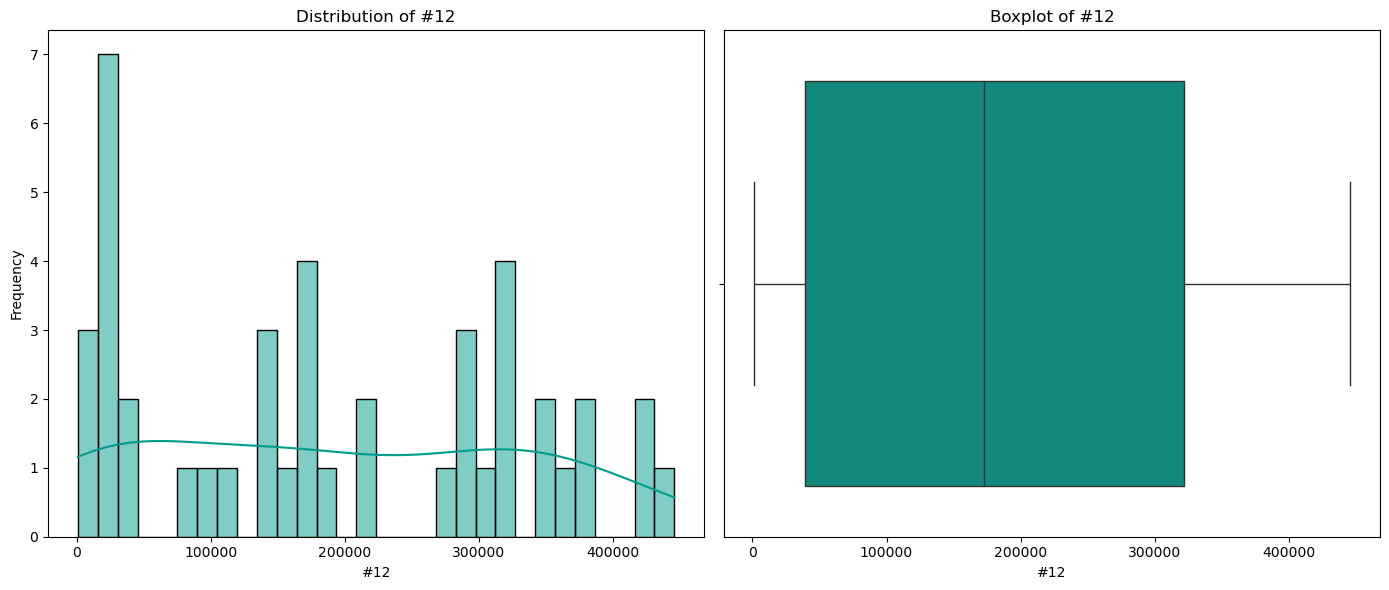

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[8], 
                              n_bins=30)

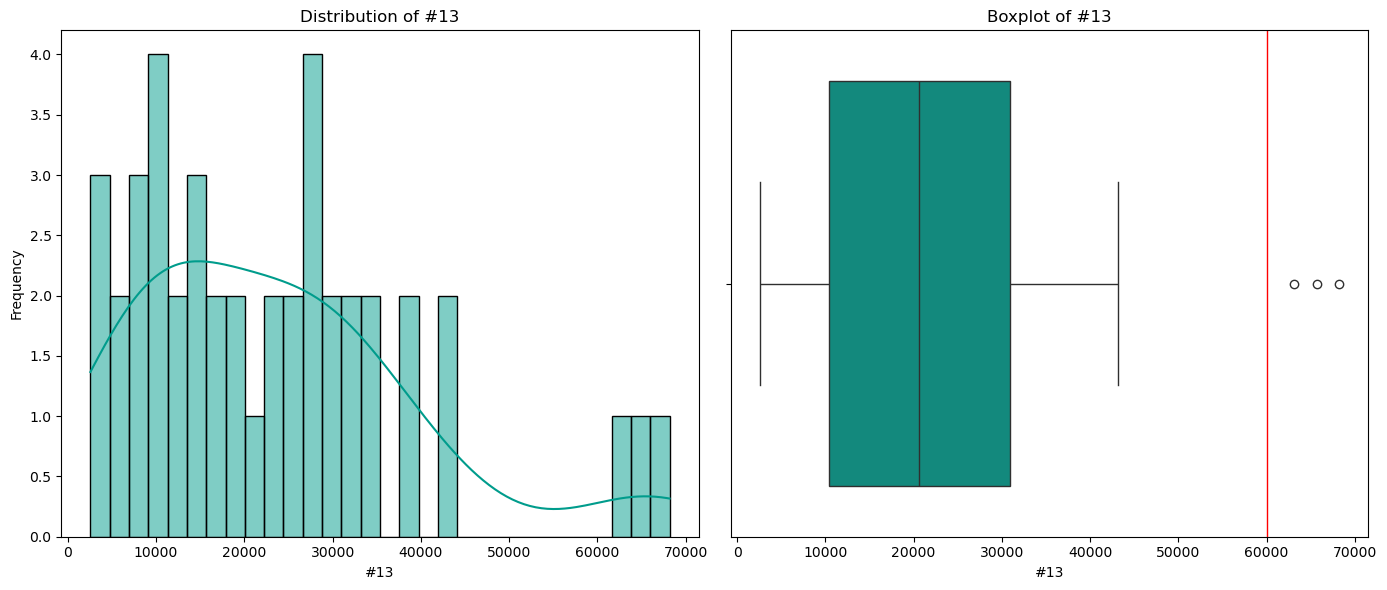

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[9], 
                              n_bins=30,
                              out_right = 60000)

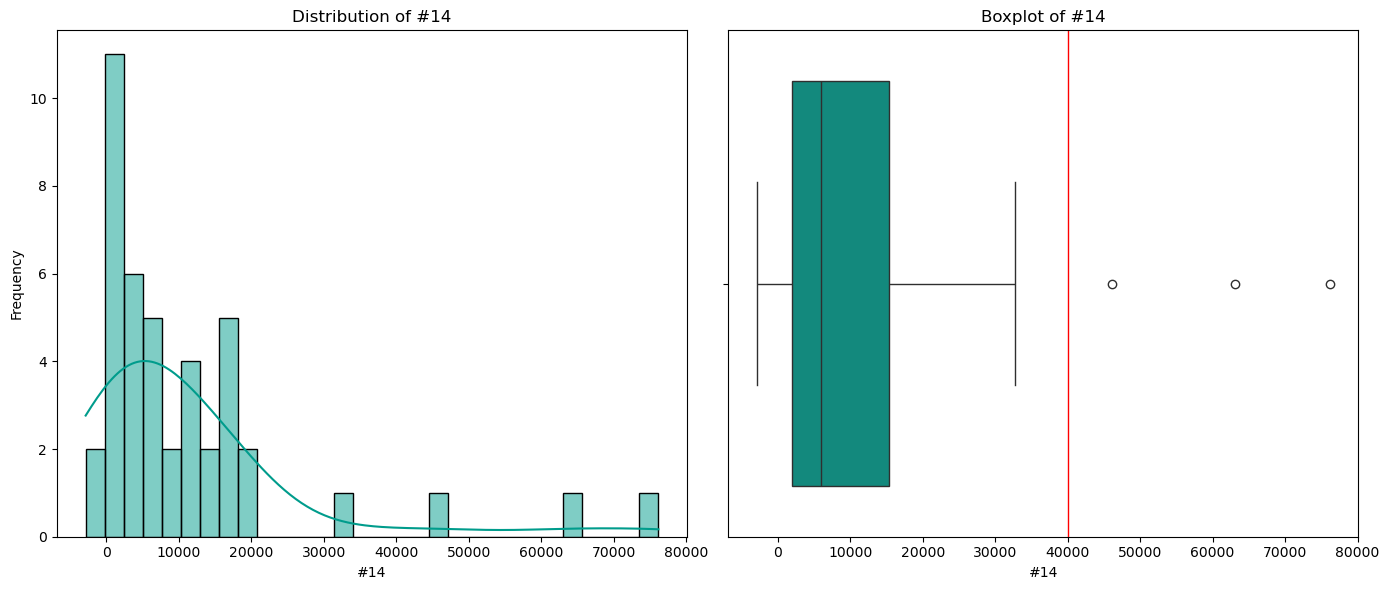

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[10], 
                              n_bins=30,
                              out_right = 40000)

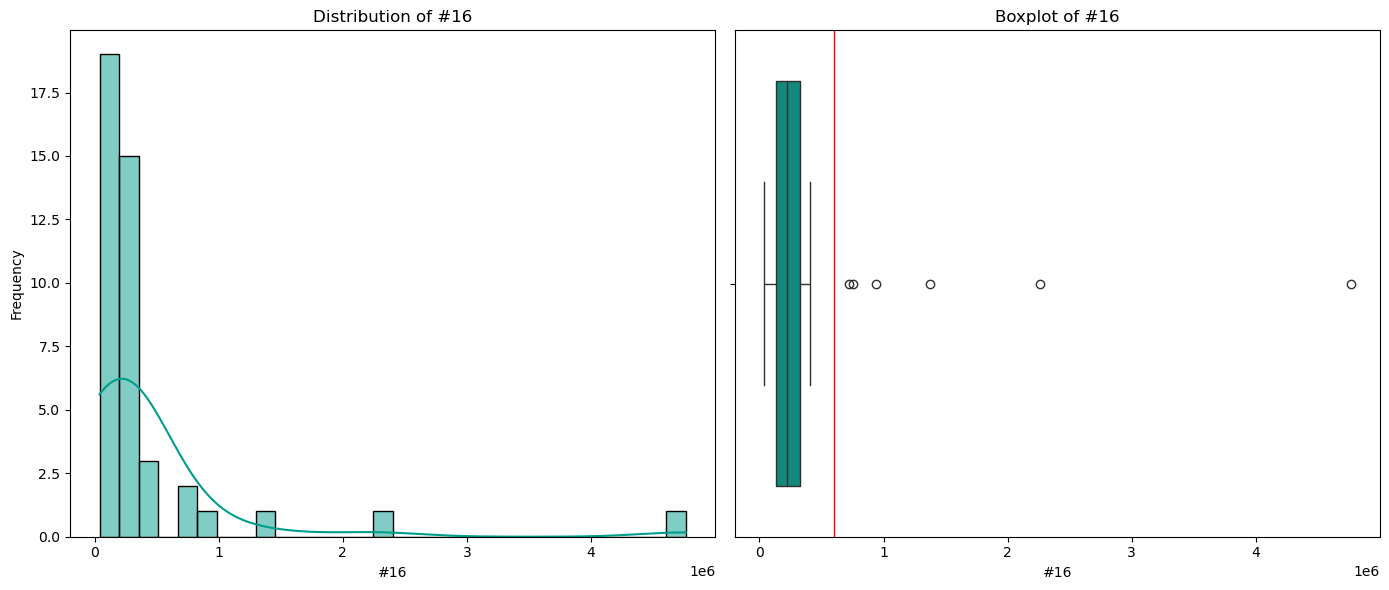

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[11], 
                              n_bins=30,
                              out_right = 600000)

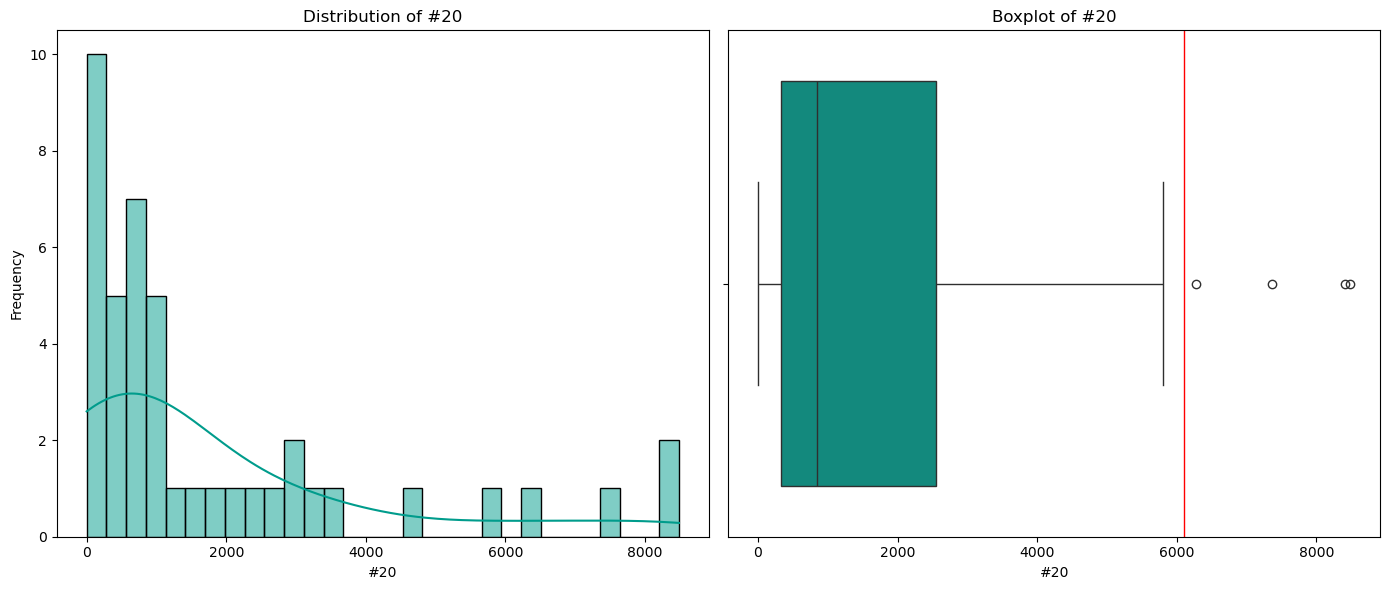

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[12], 
                              n_bins=30,
                              out_right = 6100)

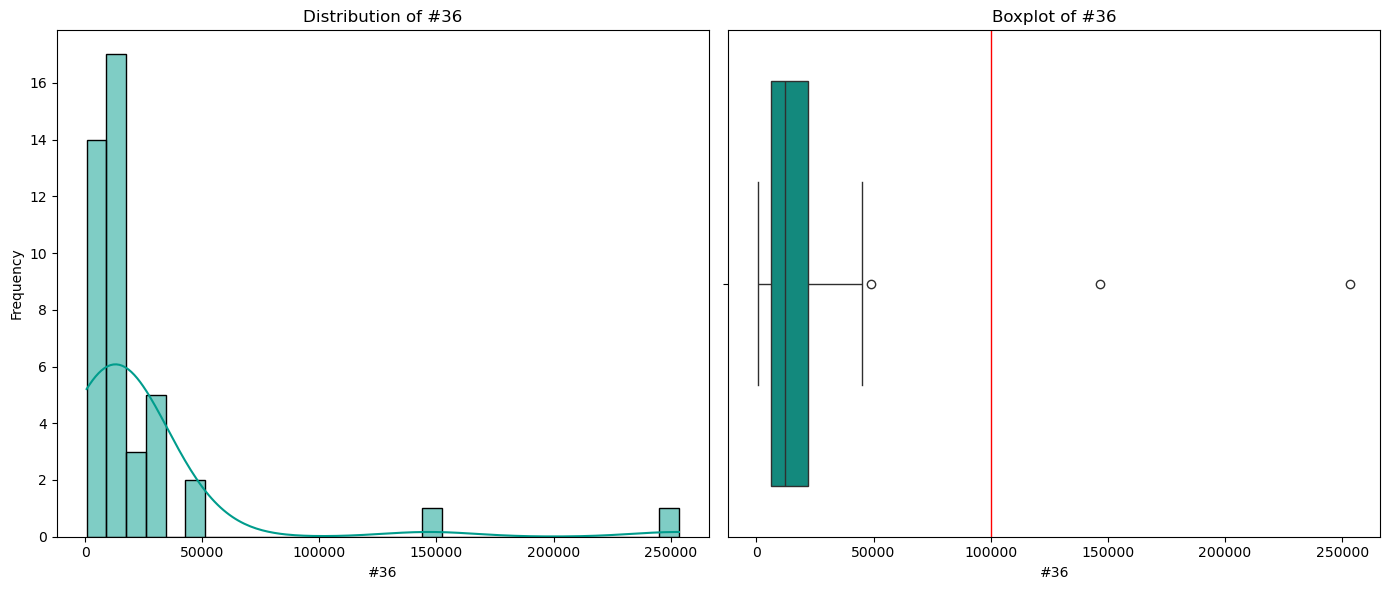

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[13], 
                              n_bins=30,
                              out_right = 100000)

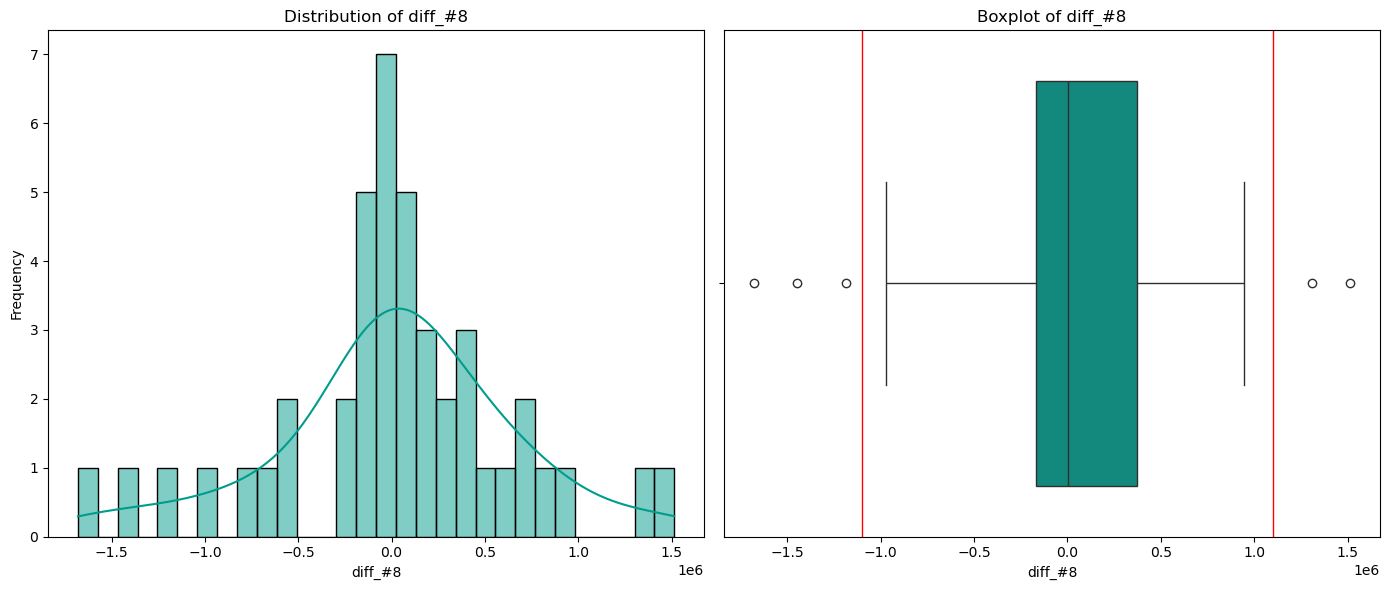

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[14], 
                              n_bins=30,
                              out_left = -1100000,
                              out_right = 1100000)

**Treating Outliers**

<div class="alert-danger">
    
NEED TO DECIDE

**Final Datasets**

- create 1 dataset per product

In [ ]:
import re

# List to store the dataframe names
df_names = []

# Find the start date of the new_monthly_sales dataset
start_date = new_monthly_sales.index.min()

# Filter market_data to match the start date of new_monthly_sales
market_data_filtered = market_data[market_data.index >= start_date]

# Loop through each column in new_monthly_sales
for col in new_monthly_sales.columns:
    # Extract the numeric part of the column name using regular expressions
    numeric_part = re.sub(r'\D', '', col)  # This removes any non-numeric characters
    
    # Create the dataframe and save it using globals()
    if col != 'diff_#8':
        df_name = f'df_{numeric_part}'
    else:
        df_name = 'df_8_diff'
    
    # Concatenate only the relevant portion of new_monthly_sales and market_data
    globals()[df_name] = pd.concat([new_monthly_sales[[col]], market_data_filtered], axis=1)
    
    # Add the dataframe name to the list
    df_names.append(df_name)



In [ ]:
df_names

['df_1',
 'df_3',
 'df_4',
 'df_5',
 'df_6',
 'df_8',
 'df_9',
 'df_11',
 'df_12',
 'df_13',
 'df_14',
 'df_16',
 'df_20',
 'df_36',
 'df_8_diff']

In [ ]:
df_1

#1  CHI Production Index  CHI Shipments Index  \
Date                                                                 
2018-10-01  36098918.79            211.955755           211.955755   
2018-11-01   5140760.00            220.519655           220.519655   
2018-12-01  37889612.12            241.846854           241.846854   
2019-01-01  27728148.35            175.668147           175.668147   
2019-02-01  34793163.53            175.668147           175.668147   
2019-03-01  33856803.04            261.642802           261.642802   
2019-04-01  39688292.01            219.595813           219.595813   
2019-05-01  38897974.29            234.169196           234.169196   
2019-06-01  39106750.23            261.126350           261.126350   
2019-07-01  37912572.30            217.053447           217.053447   
2019-08-01  38042677.05            207.815420           207.815420   
2019-09-01  40602780.64            215.853833           215.853833   
2019-10-01  39012299.19            226.669259           226.669259   
2019-11-01  37323903.07            240.953763           240.953763   
2019-12-01  37701509.37            262.913997           262.913997   
2020-01-01  34116651.47            130.439177           130.439177   
2020-02-01  33505879.26            130.439177           130.439177   
2020-03-01  39064430.88            255.237921           255.237921   
2020-04-01  37981531.32            241.111182           241.111182   
2020-05-01  31400212.54            255.808160           255.808160   
2020-06-01  30896804.07            283.339382           283.339382   
2020-07-01  35212730.13            243.892210           243.892210   
2020-08-01  37482085.58            233.073194           233.073194   
2020-09-01  38879360.20            244.074699           244.074699   
2020-10-01  41453854.50            258.380616           258.380616   
2020-11-01  37643611.57            274.401951           274.401951   
2020-12-01  34816959.18            296.243834           296.243834   
2021-01-01  27180432.94            214.843002           214.843002   
2021-02-01  34630522.81            214.843002           214.843002   
2021-03-01  33476138.64            309.574752           309.574752   
2021-04-01  41257397.90            282.420831           282.420831   
2021-05-01  37760015.28            291.521687           291.521687   
2021-06-01  35801398.47            321.742425           321.742425   
2021-07-01  37130004.21            264.032744           264.032744   
2021-08-01  36310817.42            253.723069           253.723069   
2021-09-01  36278886.58            259.000496           259.000496   
2021-10-01  44483013.86            269.794432           269.794432   
2021-11-01  34187395.60            291.520030           291.520030   
2021-12-01  33950069.83            310.763183           310.763183   
2022-01-01  37942942.06            235.956129           235.956129   
2022-02-01  36293076.33            235.956129           235.956129   
2022-03-01  40220407.03            329.413367           329.413367   
2022-04-01  41053203.12            267.373145           267.373145   

            FRA Production Index  FRA Shipments Index  GER Production Index  \
Date                                                                          
2018-10-01            108.280608           122.451734            124.227879   
2018-11-01             99.636911           115.958210            127.404132   
2018-12-01             94.690312           115.128469            120.518565   
2019-01-01             90.143775           108.325154            104.776326   
2019-02-01             92.551521           108.944656            109.597012   
2019-03-01            107.861788           126.966216            122.534648   
2019-04-01             98.677844           114.917432            110.612414   
2019-05-01             94.779550           110.814496            115.712333   
2019-06-01             98.978105           122.045555            108.917455   
2

## 5.6 Feature Selection

### Variable #1